## Original Confusion Matrices

In [ ]:
import os
import scanpy as sc
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Common path where your annotated_adata_{i}.h5ad files are located
# naive_common_path = "/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/adata_matrices/cell_annotations/annotated_adata_matrices"
naive_common_path = "/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ur_objects/adata_matrices/cell_annotations/annotated_adata_matrices"

# The ground truth file (UMI length = 12)
ground_truth_file = os.path.join(naive_common_path, "annotated_adata_12.h5ad")
ground_truth_adata = sc.read_h5ad(ground_truth_file)

# Loop through UMI lengths from 1 to 12
for i in range(1, 13):
    print(f"Processing UMI length = {i} ...")
    
    # Path to the annotated file for the current UMI length
    naive_file = os.path.join(naive_common_path, f"annotated_adata_{i}.h5ad")
    
    # Read the naive predictions for UMI length = i
    naive_adata = sc.read_h5ad(naive_file)
    
    # Align datasets based on cell names if necessary
    if not all(naive_adata.obs_names == ground_truth_adata.obs_names):
        print(f"  Warning: Cell names do not match exactly for UMI length {i}. Aligning datasets using intersection.")
        common_cells = naive_adata.obs_names.intersection(ground_truth_adata.obs_names)
        naive_adata = naive_adata[common_cells].copy()
        gt_aligned = ground_truth_adata[common_cells].copy()
    else:
        gt_aligned = ground_truth_adata
    
    # Extract predicted (naive) and ground truth labels
    y_pred = naive_adata.obs['majority_voting'].astype(str)
    y_true = gt_aligned.obs['majority_voting'].astype(str)
    
    # Get all labels present in either the predictions or the ground truth
    labels = np.unique(np.concatenate([y_true, y_pred]))
    
    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    
    # Plot the confusion matrix
    fig, ax = plt.subplots(figsize=(10, 8))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap=plt.cm.Blues, ax=ax)
    
    # Rotate x-axis labels by 90 degrees to make them vertical
    plt.setp(ax.get_xticklabels(), rotation=90, ha="center")
    
    plt.title(f"1k Naive (Predictions vs. Ground Truth) - UMI length = {i}")
    plt.tight_layout()
    # plt.savefig(f"/data/dagyeman/cellranger/bam_file_analysis/figures_ub/confusion_matrices/1k_naive/confusion_matrix_UMI_{i}.pdf")
    plt.savefig(f"/data/dagyeman/cellranger/bam_file_analysis/figures_ur/confusion_matrices/1k_naive/confusion_matrix_UMI_{i}.pdf")
    # Show the plot (or save it, if desired)
    plt.show()

## New confusion Matrices

### Naive 

Uniform consensus (all 5 agree):   1028/1232 = 83.44%
Mixed consensus (any split):       204/1232 = 16.56%

Processing UMI length = 1 …


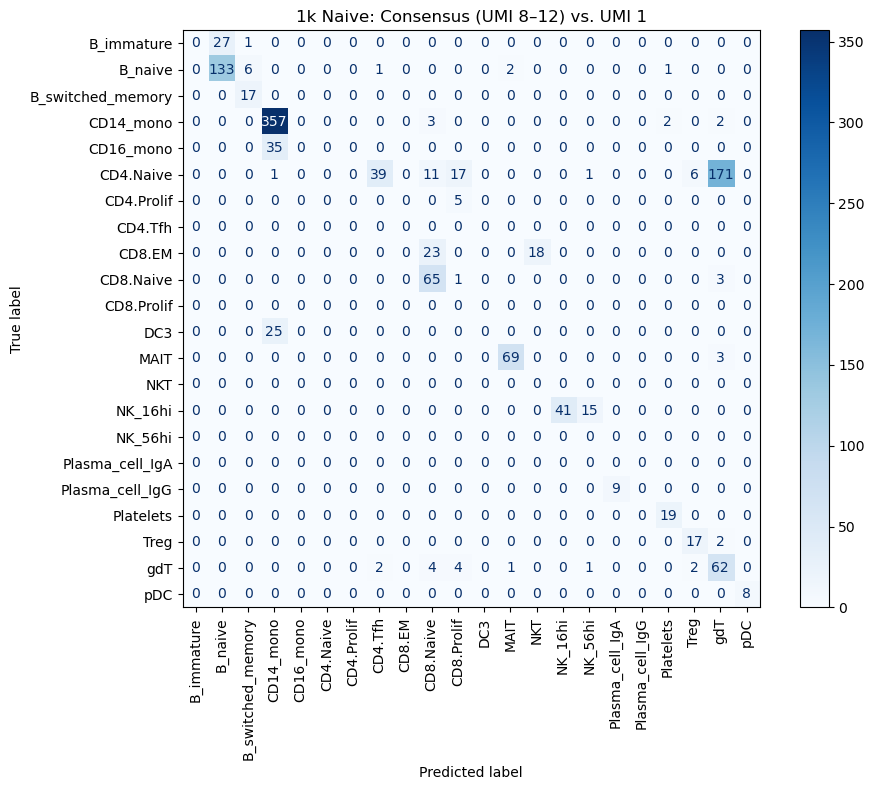

Processing UMI length = 2 …


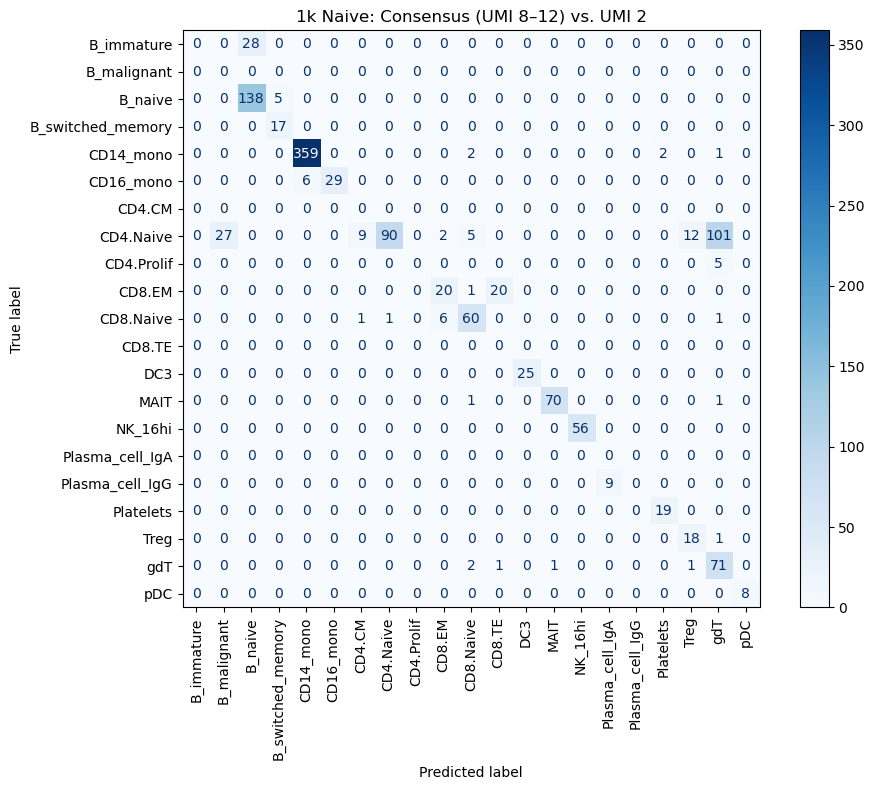

Processing UMI length = 3 …


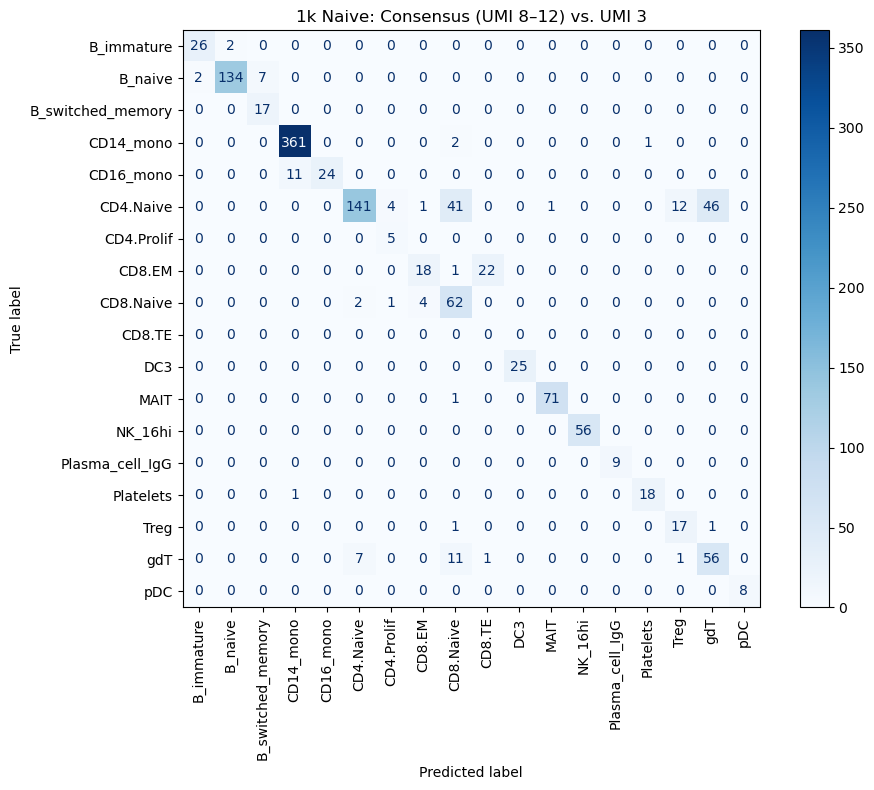

Processing UMI length = 4 …


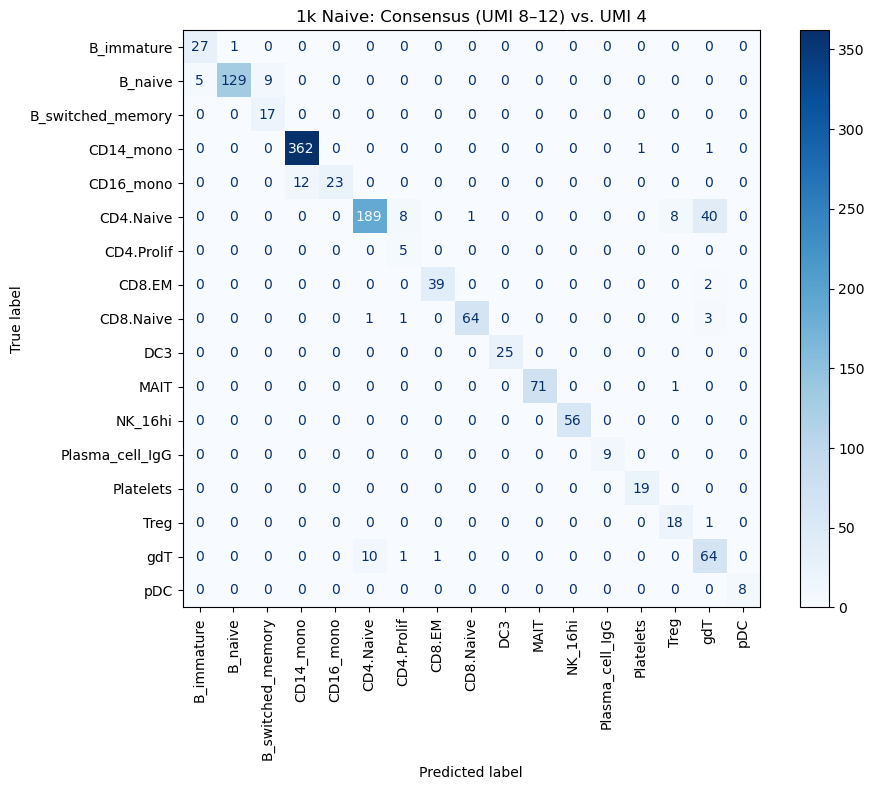

Processing UMI length = 5 …


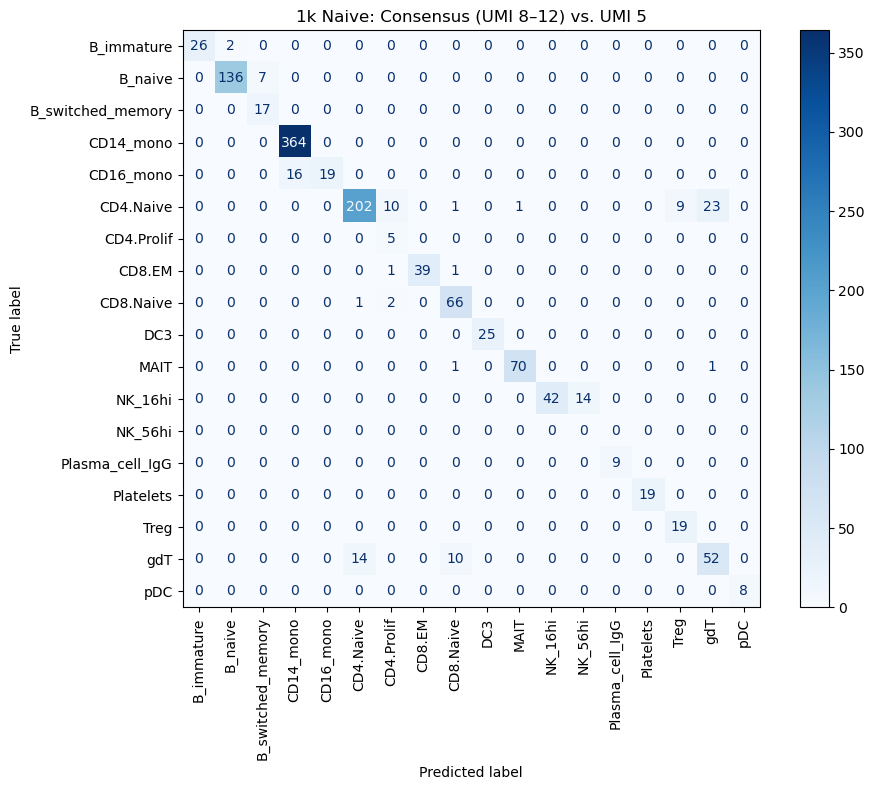

Processing UMI length = 6 …


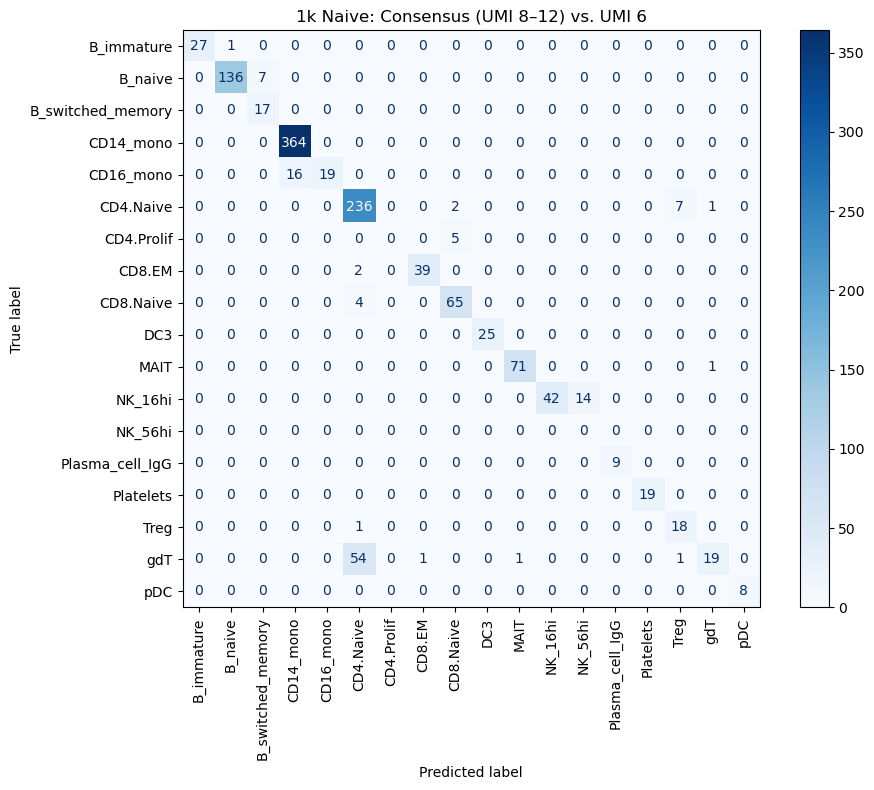

Processing UMI length = 7 …


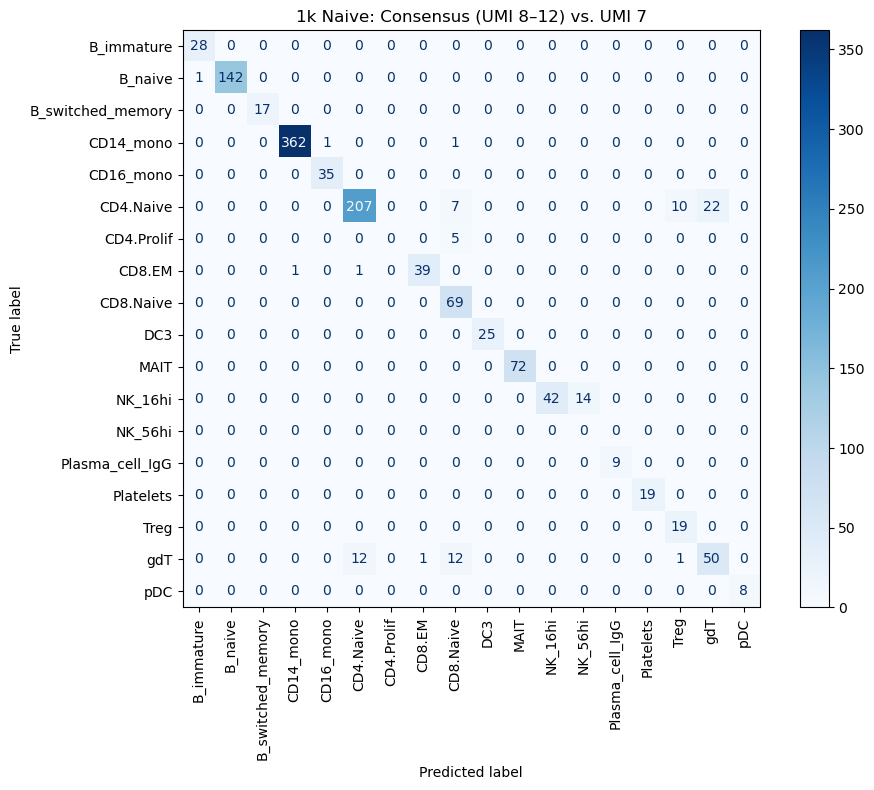

Processing UMI length = 8 …


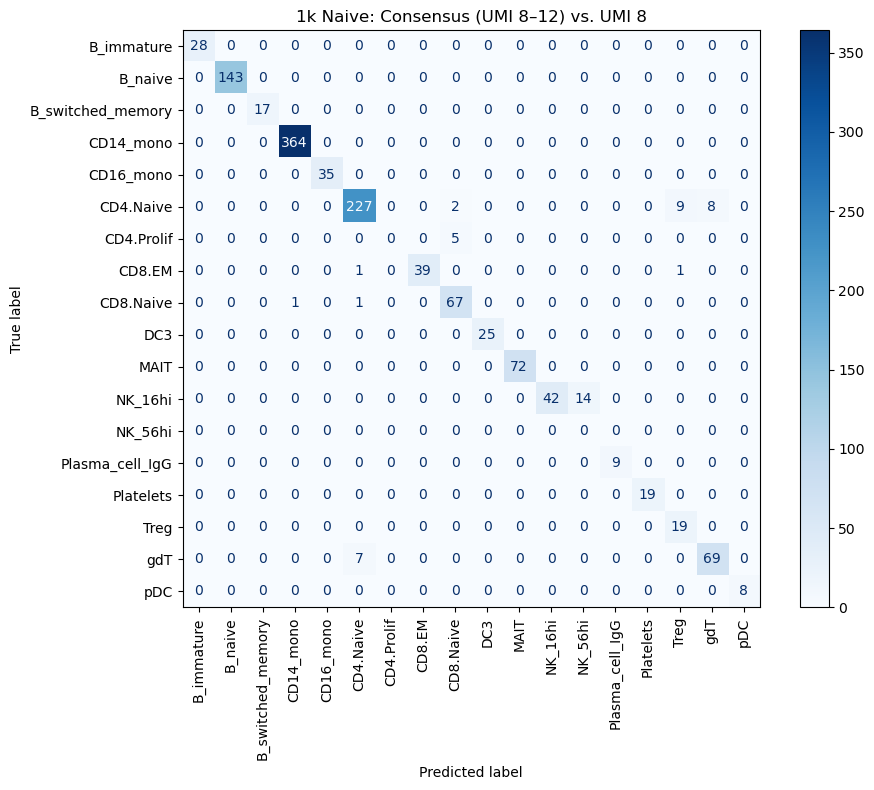

Processing UMI length = 9 …


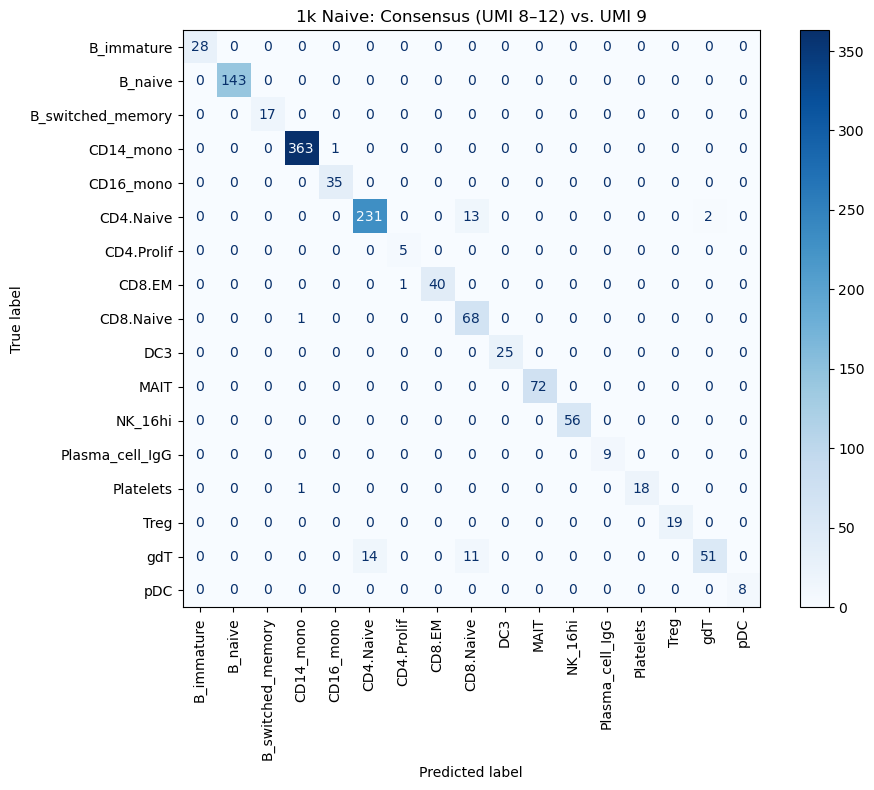

Processing UMI length = 10 …


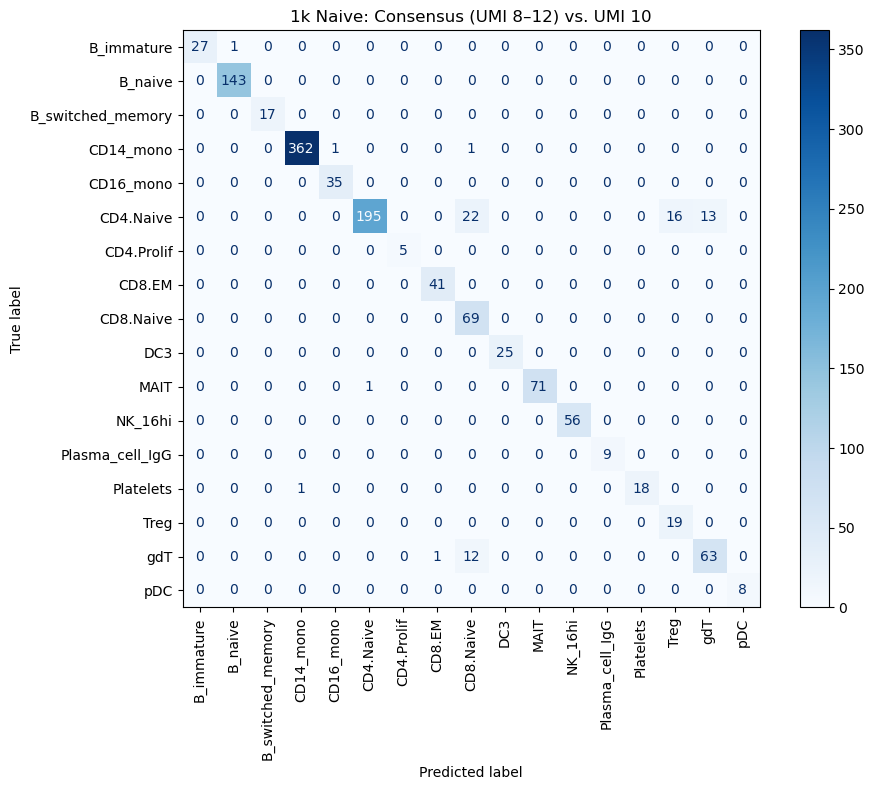

Processing UMI length = 11 …


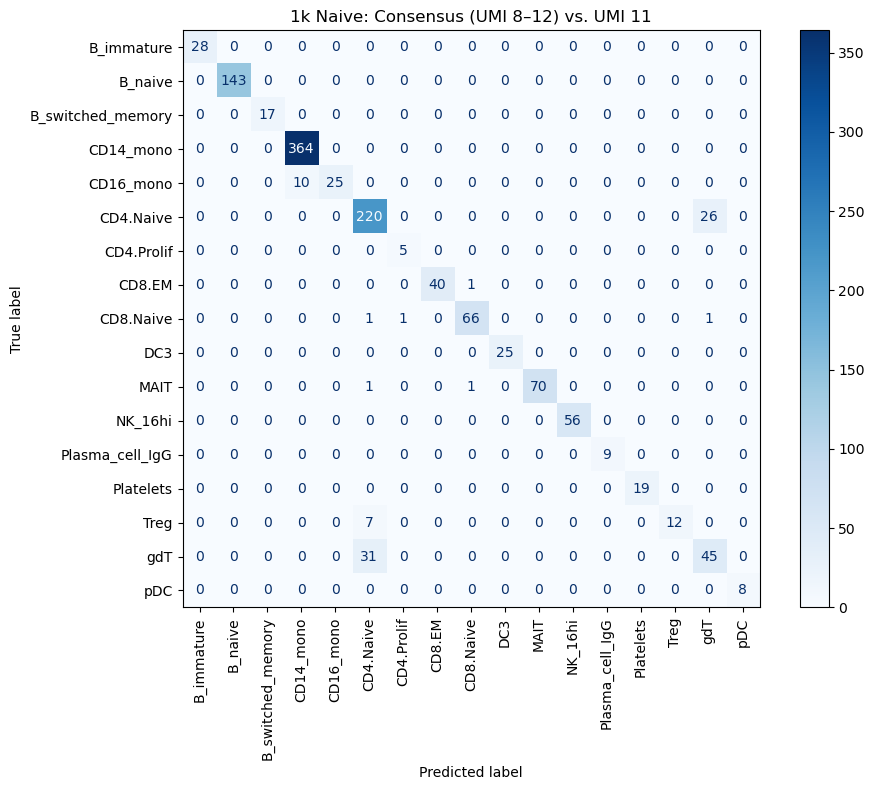

Processing UMI length = 12 …


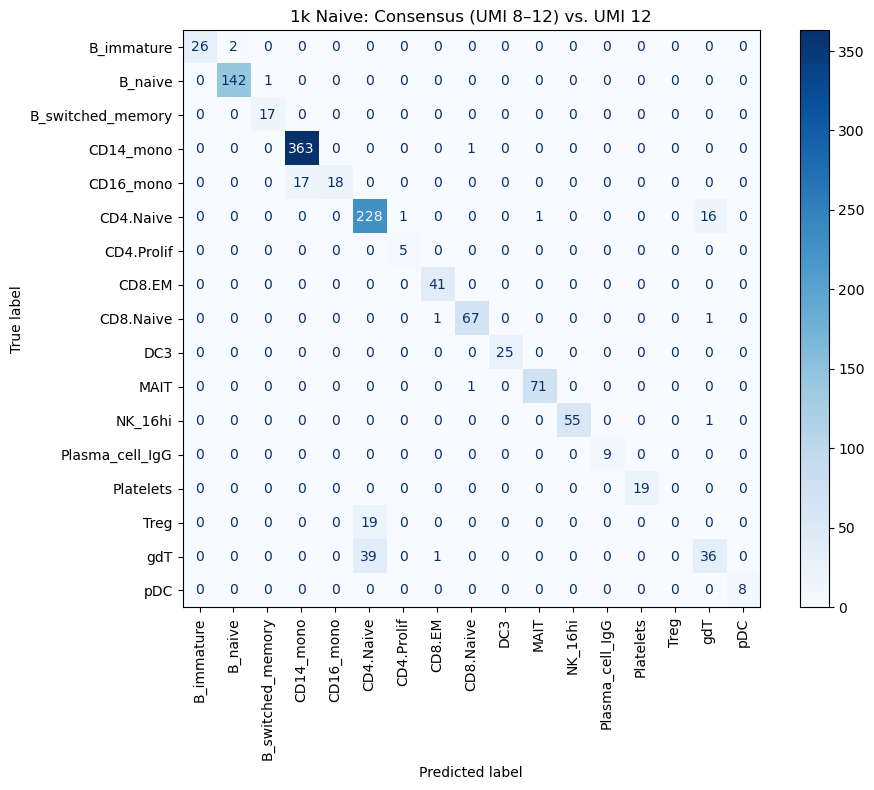

In [6]:
import os
import scanpy as sc
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from collections import Counter
import numpy as np

# Path to all your annotated files
base_path = "/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ur_objects/adata_matrices/cell_annotations/annotated_adata_matrices"

# 1) Load the AnnData objects for UMI lengths 8–12
ensemble_adatas = {
    i: sc.read_h5ad(os.path.join(base_path, f"annotated_adata_{i}.h5ad"))
    for i in range(8, 13)
}

# 2) Find the intersection of cells present in all five adatas
common_cells = set(ensemble_adatas[8].obs_names)
for ad in ensemble_adatas.values():
    common_cells &= set(ad.obs_names)
common_cells = sorted(common_cells)

# ——— compute uniform vs. non-uniform vote stats once ———
total = len(common_cells)
uniform = sum(
    1
    for cell in common_cells
    if len({ensemble_adatas[i].obs.loc[cell, 'majority_voting'] for i in range(8, 13)}) == 1
)
non_uniform = total - uniform
pct_uniform = uniform / total * 100
pct_non_uniform = non_uniform / total * 100
# ——————————————————————————————————————————————

# Print those stats only once
print(f"Uniform consensus (all 5 agree):   {uniform}/{total} = {pct_uniform:.2f}%")
print(f"Mixed consensus (any split):       {non_uniform}/{total} = {pct_non_uniform:.2f}%\n")

# 3) Build a consensus label per cell via majority vote
consensus_labels = {}
for cell in common_cells:
    votes = [ensemble_adatas[i].obs.loc[cell, 'majority_voting'] for i in range(8, 13)]
    most_common, _ = Counter(votes).most_common(1)[0]
    consensus_labels[cell] = most_common
# Now consensus_labels[cell] is your new ground truth

# 4) Loop through UMI lengths 1–12, compare predictions to consensus
for i in range(1, 13):
    print(f"Processing UMI length = {i} …")
    
    adata = sc.read_h5ad(os.path.join(base_path, f"annotated_adata_{i}.h5ad"))
    
    # align to cells in consensus
    if not all(adata.obs_names == common_cells):
        cells = [c for c in common_cells if c in adata.obs_names]
        print(f"  Aligning to {len(cells)} common cells")
        adata = adata[cells].copy()
    
    # extract predicted vs. consensus
    y_pred = adata.obs['majority_voting'].astype(str).values
    y_true = np.array([consensus_labels[c] for c in adata.obs_names])
    
    # build label set
    labels = np.unique(np.concatenate([y_true, y_pred]))
    
    # compute & plot confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    fig, ax = plt.subplots(figsize=(10, 8))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap=plt.cm.Blues, ax=ax)
    plt.setp(ax.get_xticklabels(), rotation=90, ha="center")
    plt.title(f"1k Naive: Consensus (UMI 8–12) vs. UMI {i}")
    plt.tight_layout()
    plt.show()



### Model

Uniform consensus (all 5 agree):   1028/1232 = 83.44%
Mixed consensus (any split):       204/1232 = 16.56%

Processing UMI length = 1 …


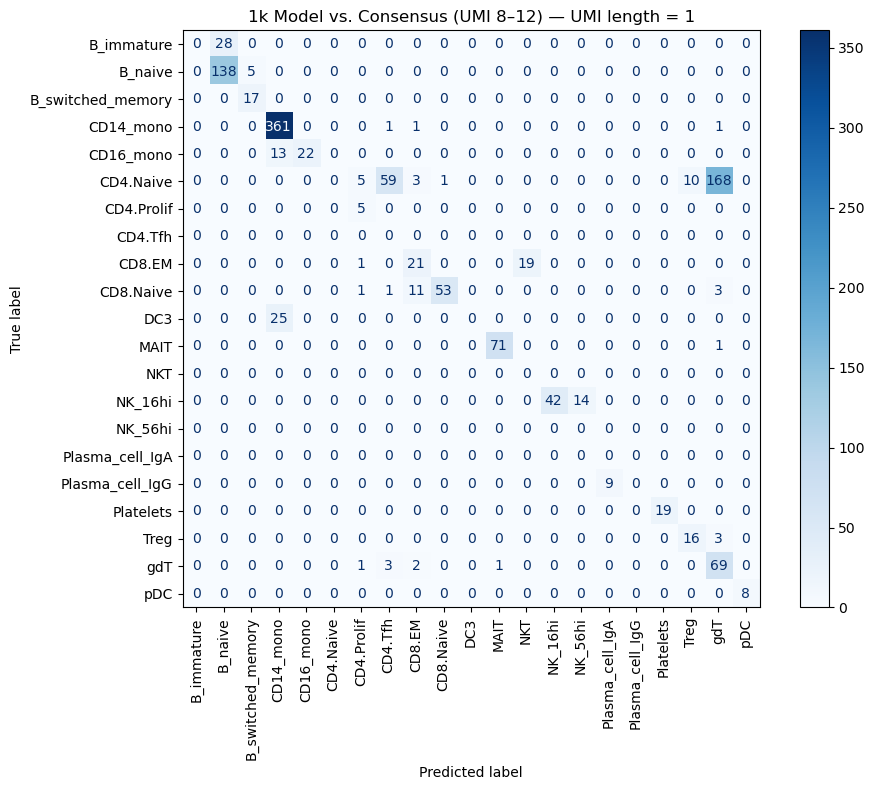

Processing UMI length = 2 …


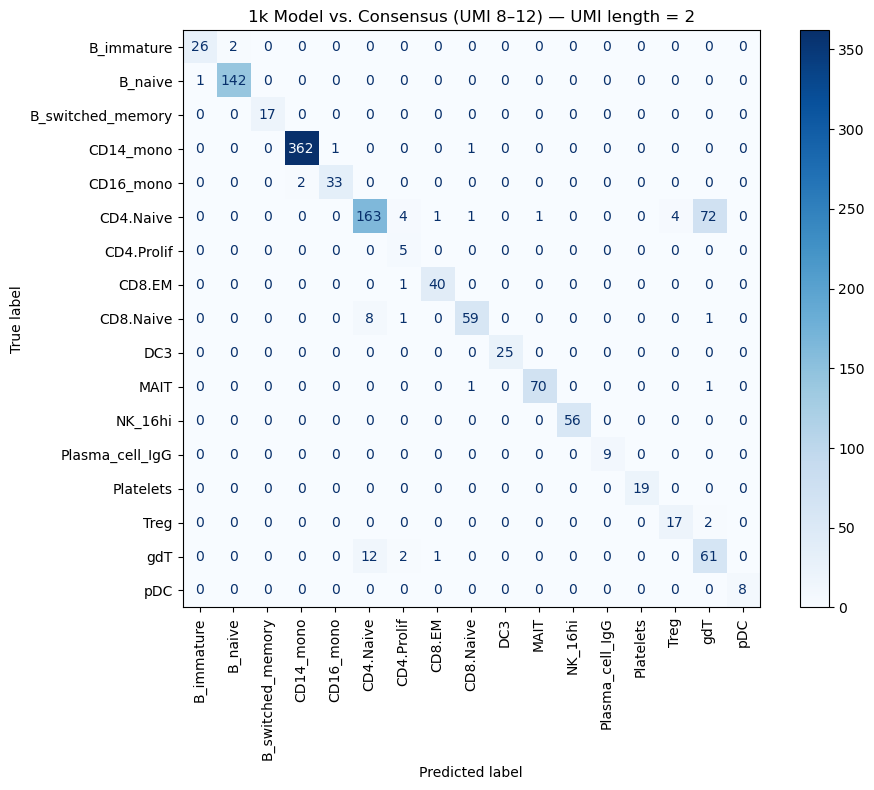

Processing UMI length = 3 …


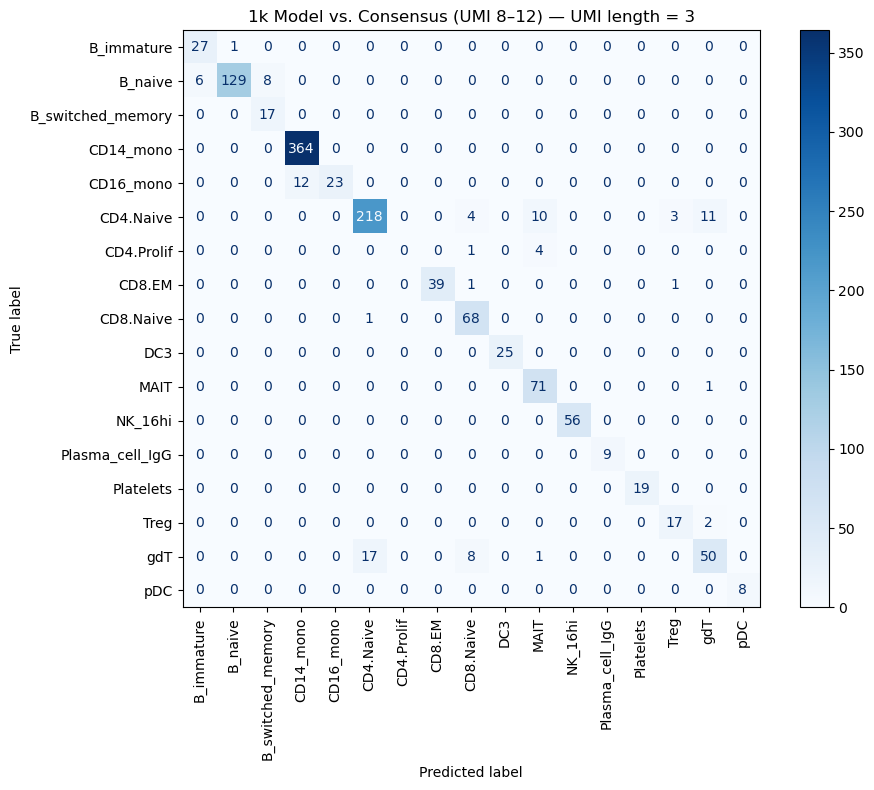

Processing UMI length = 4 …


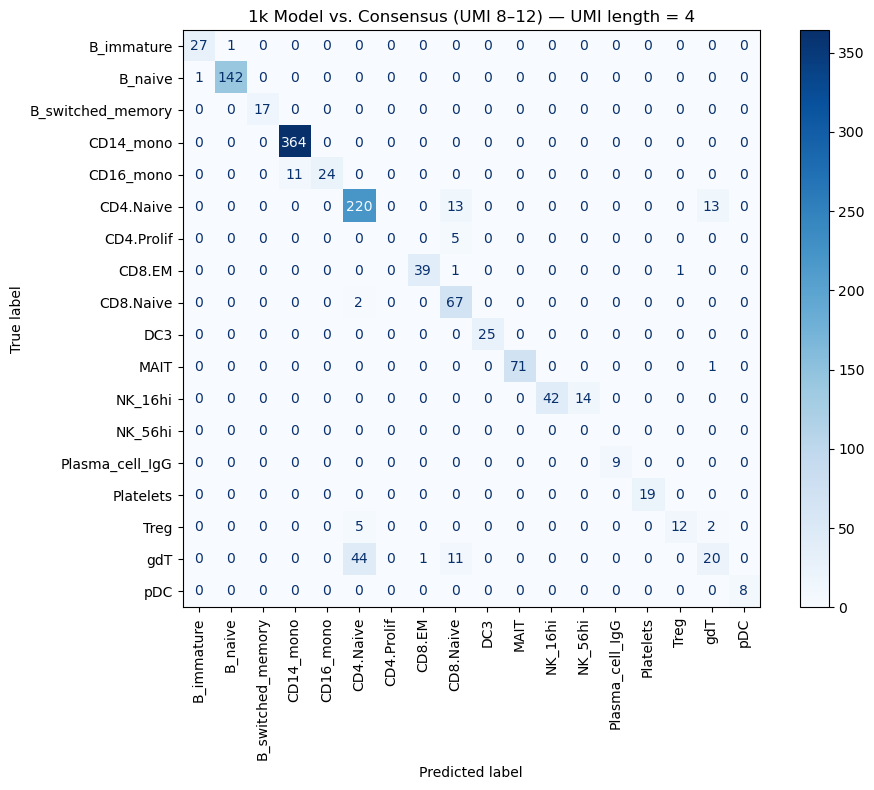

Processing UMI length = 5 …


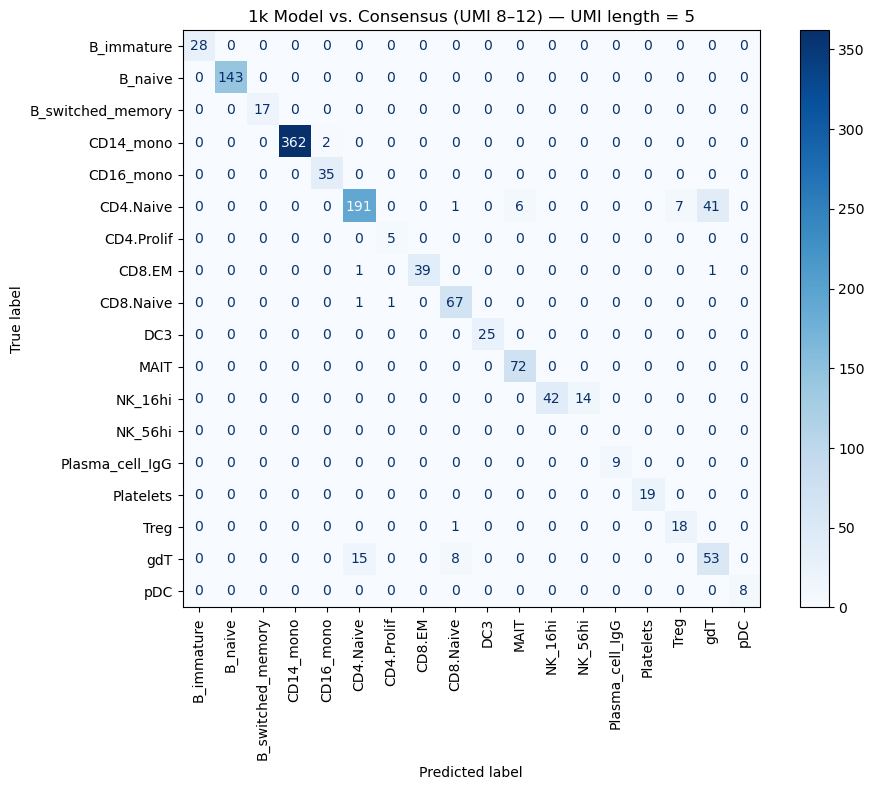

Processing UMI length = 6 …


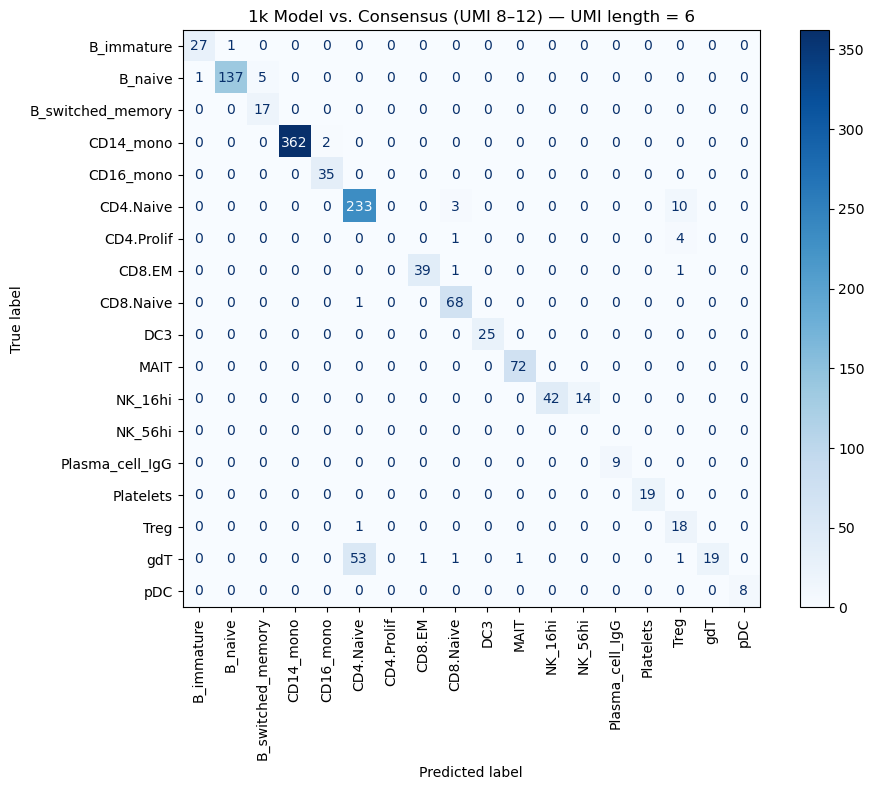

Processing UMI length = 7 …


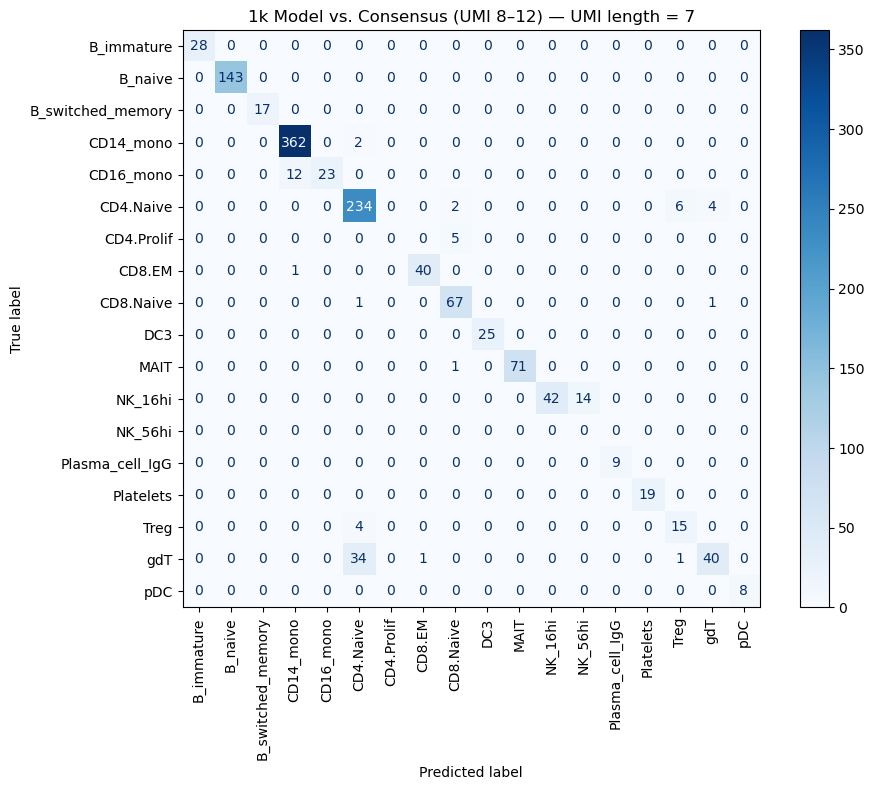

Processing UMI length = 8 …


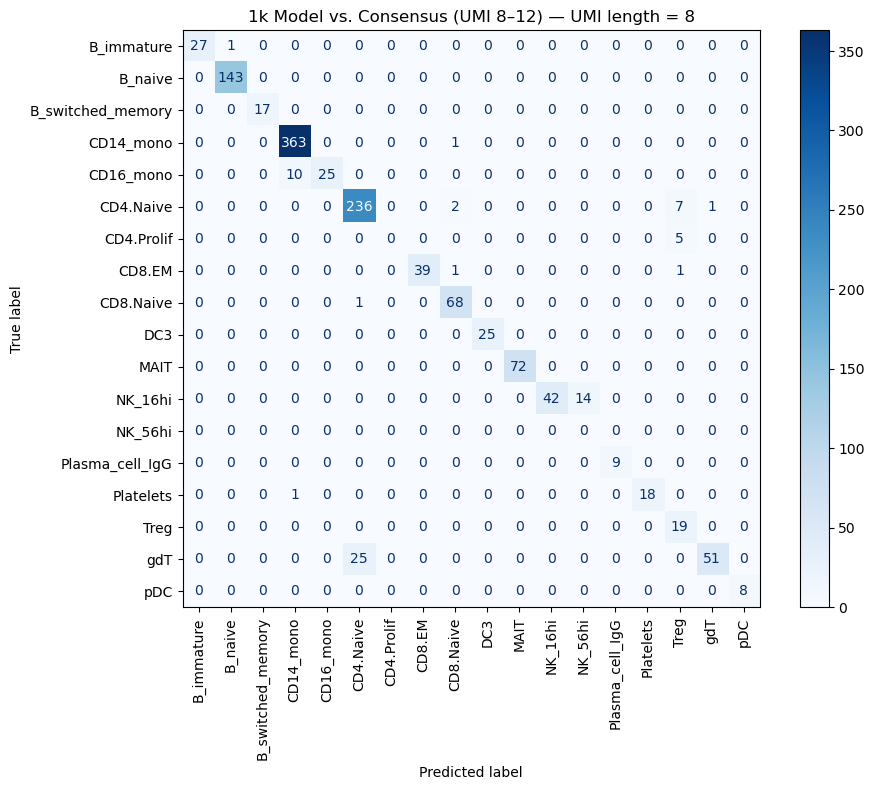

Processing UMI length = 9 …


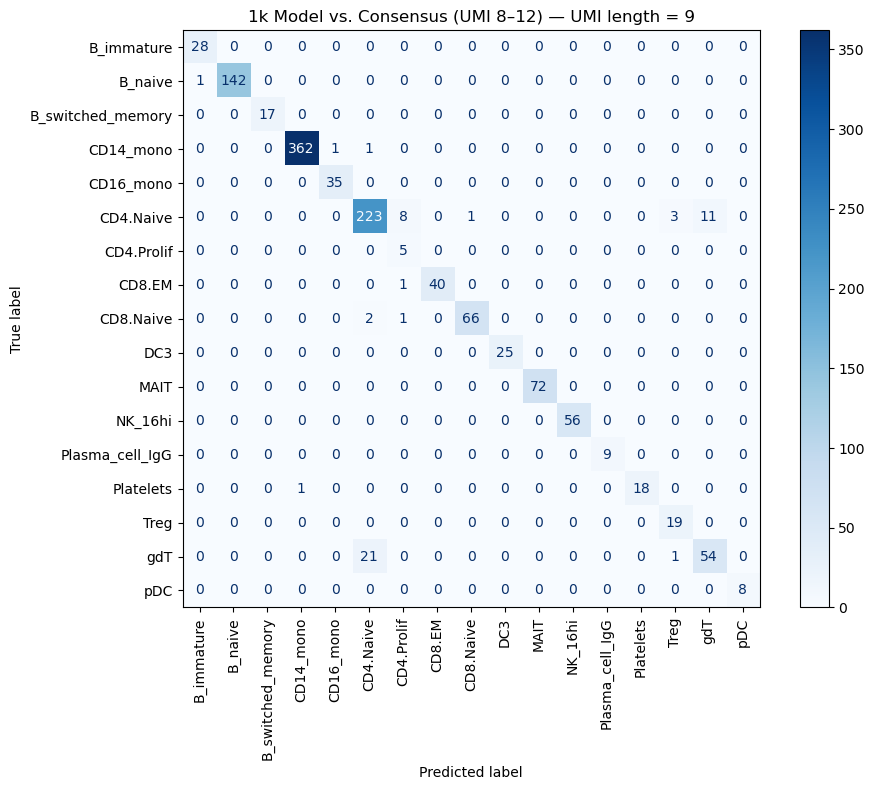

Processing UMI length = 10 …


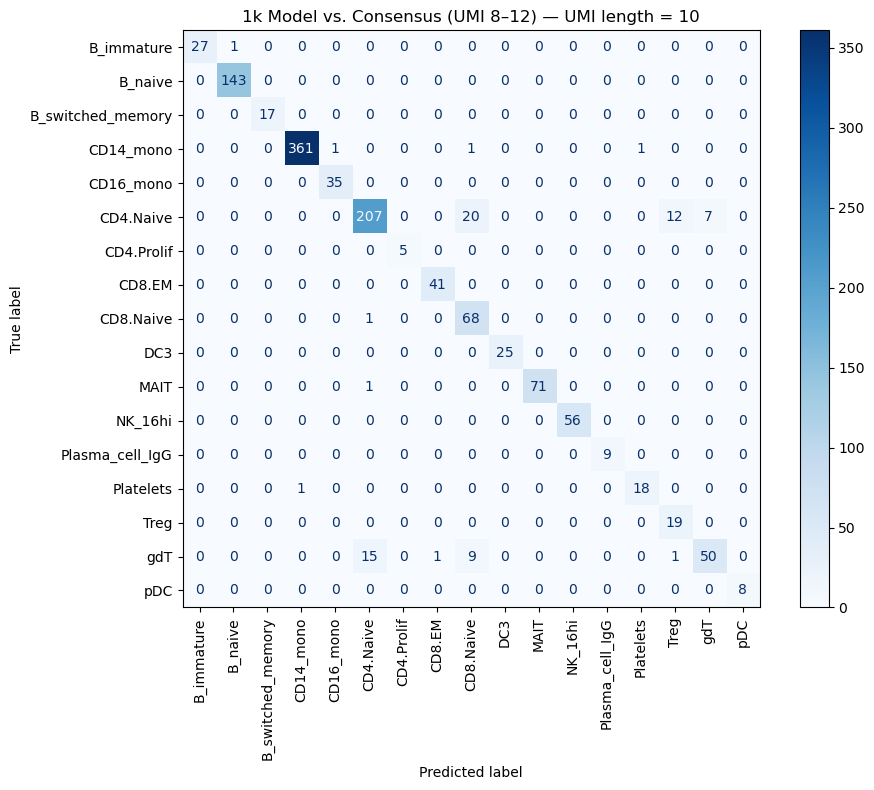

Processing UMI length = 11 …


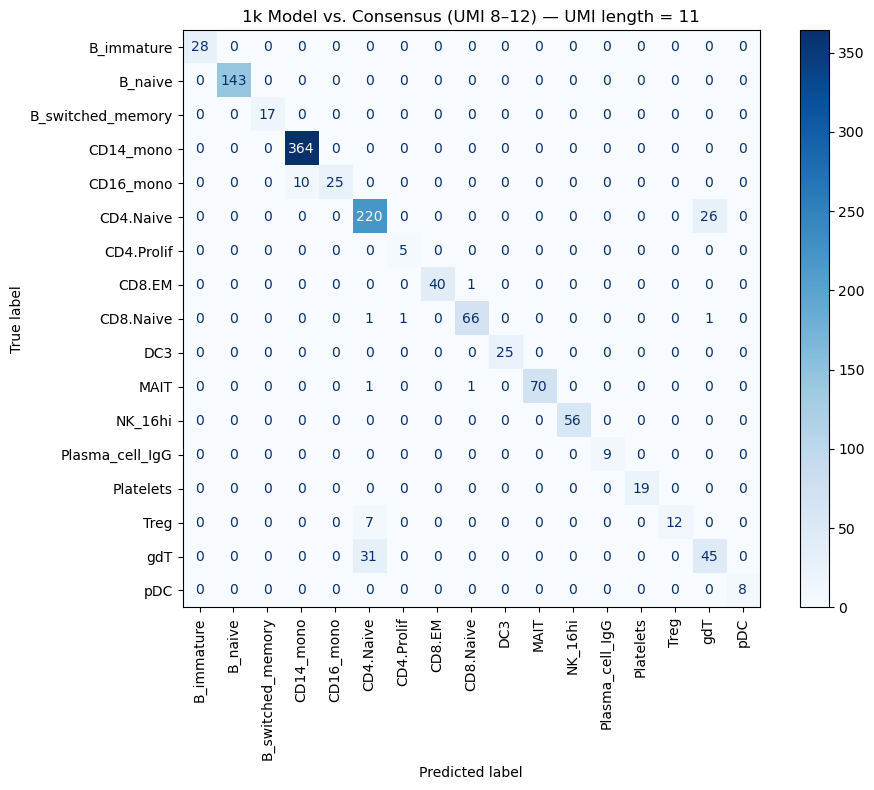

Processing UMI length = 12 …


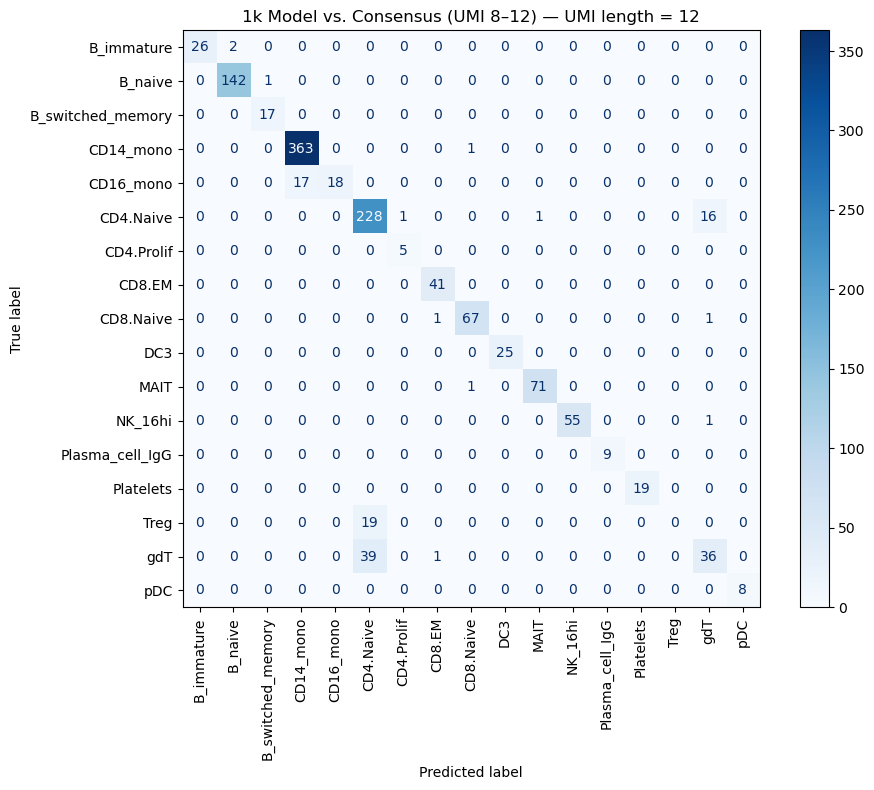

In [13]:
import os
import scanpy as sc
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from collections import Counter
import numpy as np

# 1) Paths
model_common_path = "/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ur_objects/inverted2_adata_matrices/cell_annotations/annotated_inv_matrices"
consensus_base_path = "/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ur_objects/adata_matrices/cell_annotations/annotated_adata_matrices"

# 2) Load the “ground-truth” adatas for UMI lengths 8–12
ensemble_adatas = {
    i: sc.read_h5ad(os.path.join(consensus_base_path, f"annotated_adata_{i}.h5ad"))
    for i in range(8, 13)
}

# 3) Find the intersection of cells present in all five
common_cells = set(ensemble_adatas[8].obs_names)
for ad in ensemble_adatas.values():
    common_cells &= set(ad.obs_names)
common_cells = sorted(common_cells)

# ——— compute uniform vs. non-uniform vote stats once ———
total = len(common_cells)
uniform = sum(
    1
    for cell in common_cells
    if len({ensemble_adatas[i].obs.loc[cell, 'majority_voting'] for i in range(8, 13)}) == 1
)
non_uniform = total - uniform
pct_uniform = uniform / total * 100
pct_non_uniform = non_uniform / total * 100
# ——————————————————————————————————————————————

# Print uniformity stats just once
print(f"Uniform consensus (all 5 agree):   {uniform}/{total} = {pct_uniform:.2f}%")
print(f"Mixed consensus (any split):       {non_uniform}/{total} = {pct_non_uniform:.2f}%\n")

# 4) Build consensus labels by majority vote
consensus_labels = {}
for cell in common_cells:
    votes = [ensemble_adatas[i].obs.loc[cell, 'majority_voting'] for i in range(8, 13)]
    consensus_labels[cell] = Counter(votes).most_common(1)[0][0]
# (ties broken arbitrarily by Counter.most_common)

# 5) Evaluate each inverted-model adata against the consensus
for i in range(1, 13):
    print(f"Processing UMI length = {i} …")

    inv_file = os.path.join(model_common_path, f"annotated_adata_{i}.h5ad")
    inv_adata = sc.read_h5ad(inv_file)
    
    # align to the consensus cells
    if not all(inv_adata.obs_names == common_cells):
        cells = [c for c in common_cells if c in inv_adata.obs_names]
        print(f"  Aligning to {len(cells)} common cells")
        inv_adata = inv_adata[cells].copy()
    
    # extract predictions and consensus truth
    y_pred = inv_adata.obs['majority_voting'].astype(str).values
    y_true = np.array([consensus_labels[c] for c in inv_adata.obs_names])
    
    # unify label set
    labels = np.unique(np.concatenate([y_true, y_pred]))
    
    # compute & plot confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    fig, ax = plt.subplots(figsize=(10, 8))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap=plt.cm.Blues, ax=ax)
    plt.setp(ax.get_xticklabels(), rotation=90, ha="center")
    plt.title(f"1k Model vs. Consensus (UMI 8–12) — UMI length = {i}")
    plt.tight_layout()
    out_path = f"/data/dagyeman/cellranger/bam_file_analysis/figures_ur/confusion_matrices/1k_model_consensus/consensus_vs_UMI_{i}.pdf"
    os.makedirs(os.path.dirname(out_path), exist_ok=True)
    # plt.savefig(out_path)
    plt.show()


## New Confusion Matrices - Modified

### Naive


Processing UMI length = 1 …


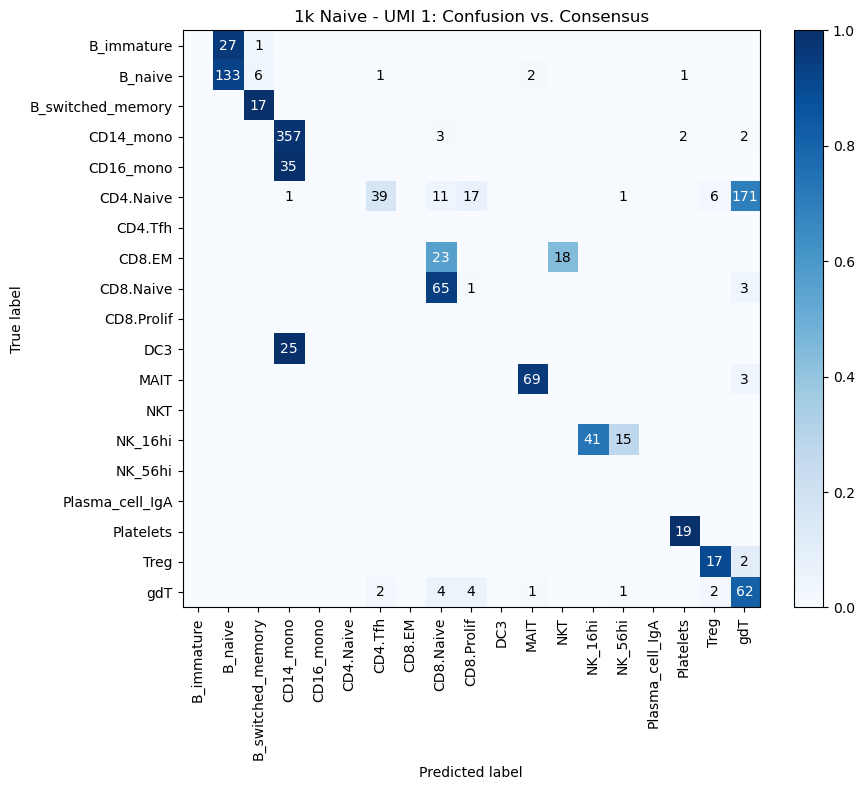


Processing UMI length = 2 …


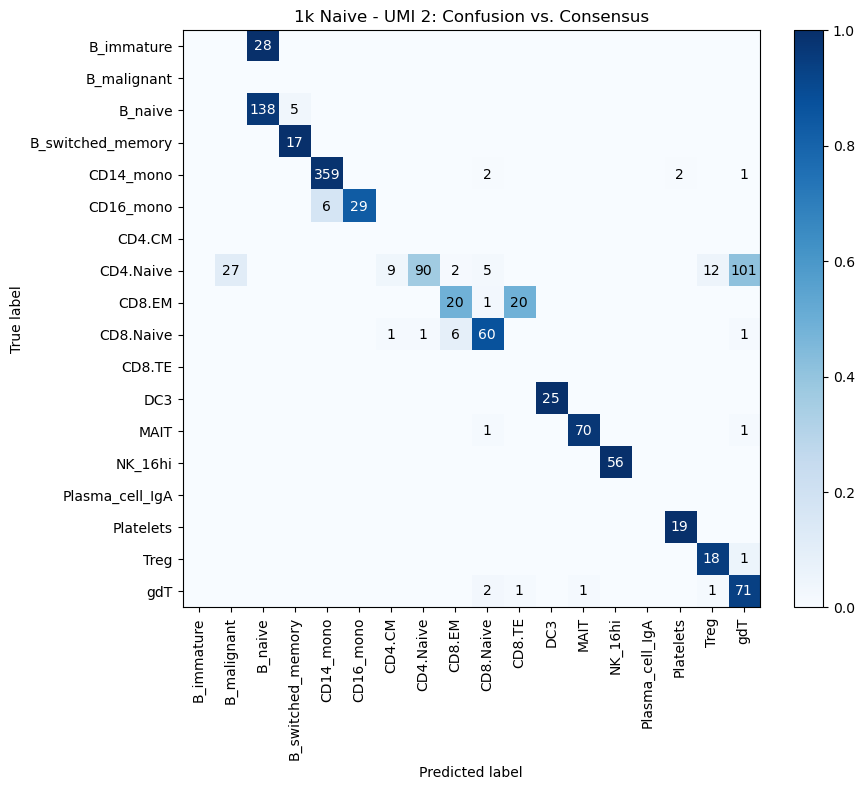


Processing UMI length = 3 …


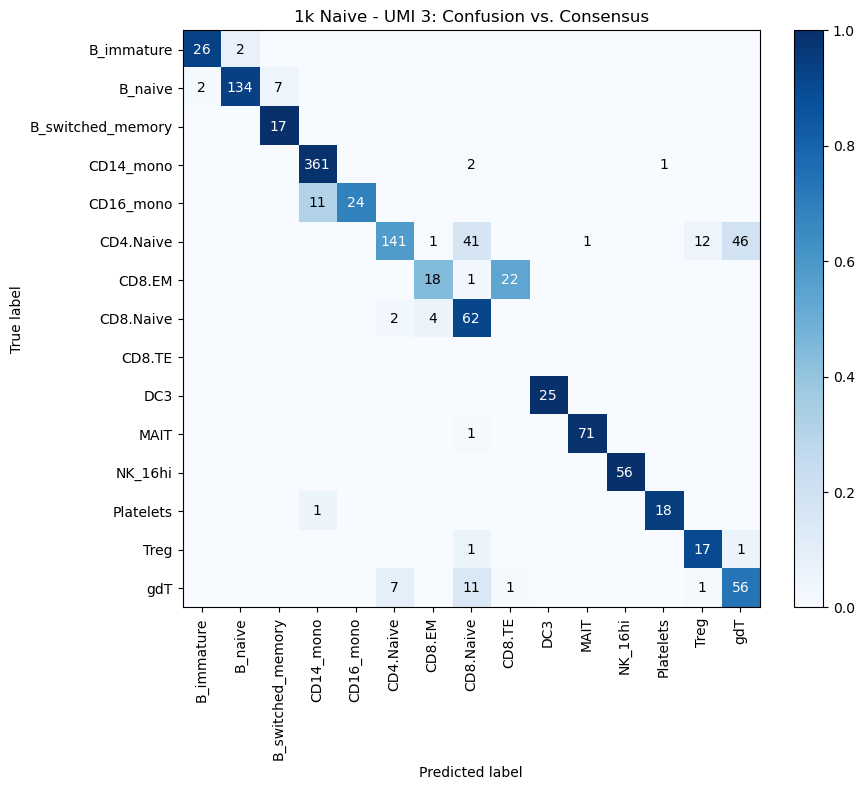


Processing UMI length = 4 …


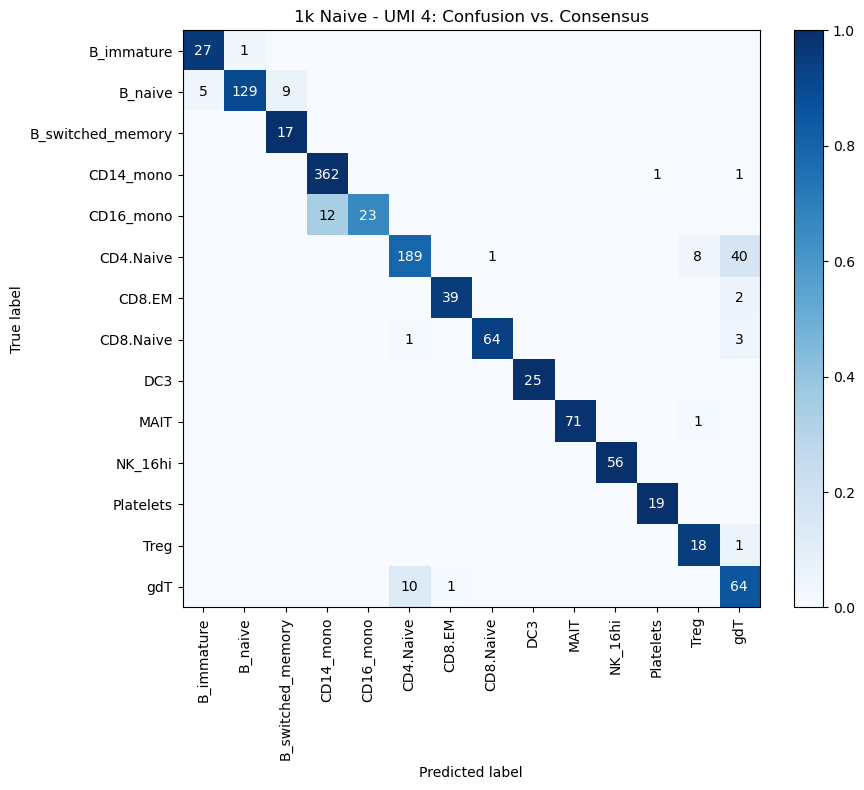


Processing UMI length = 5 …


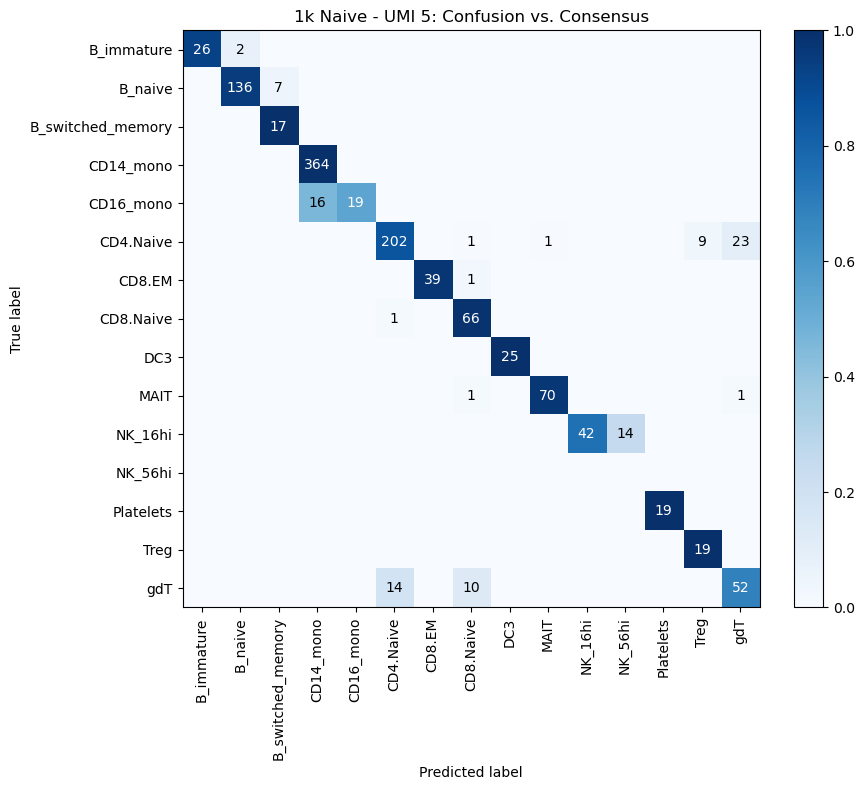


Processing UMI length = 6 …


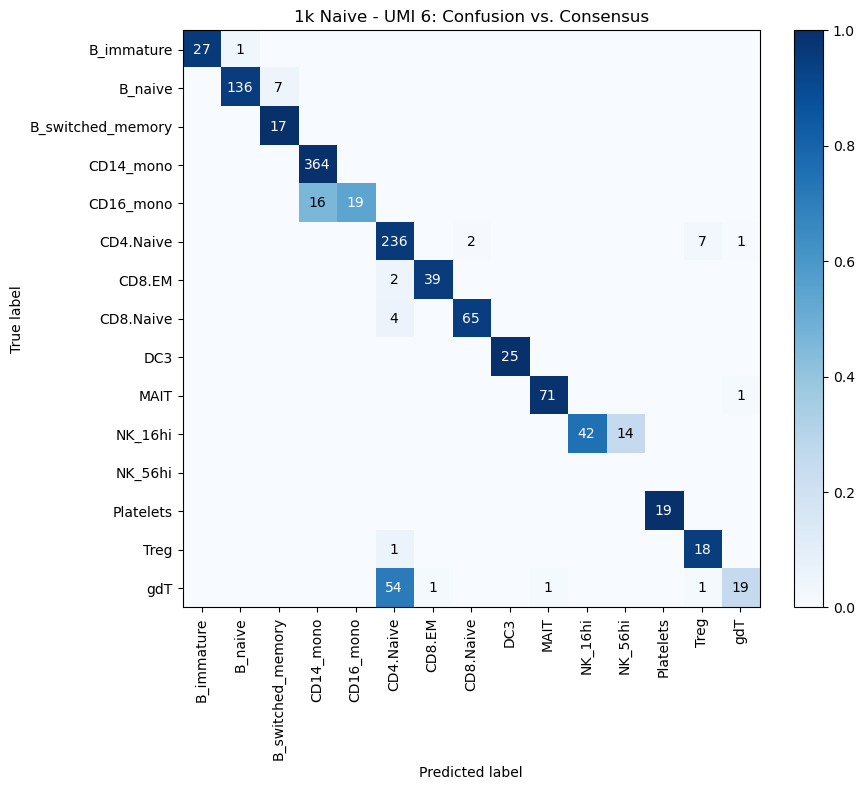


Processing UMI length = 7 …


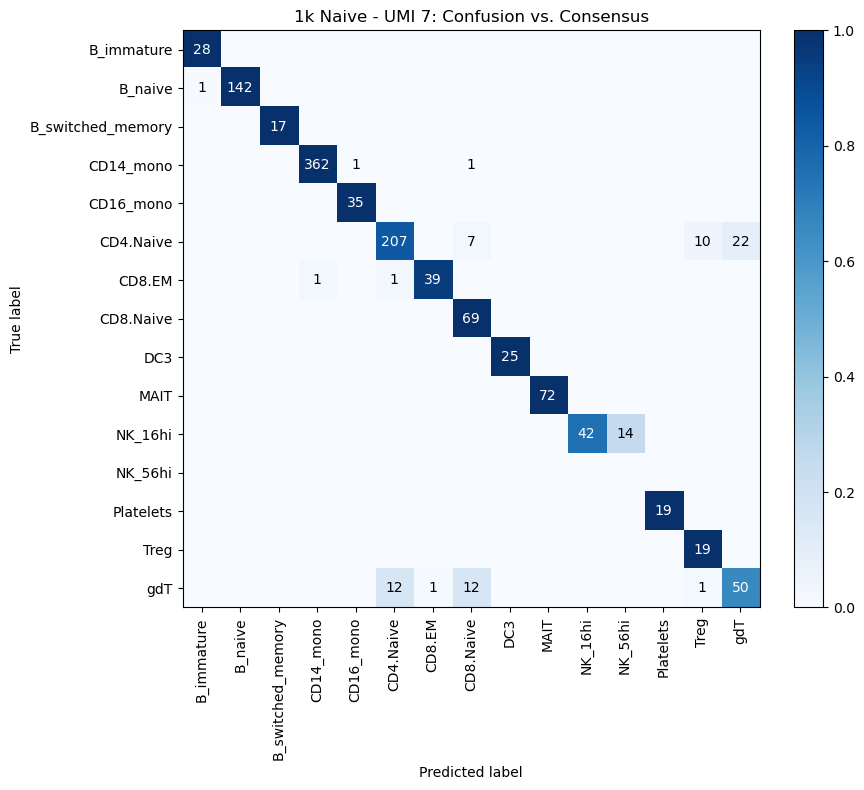


Processing UMI length = 8 …


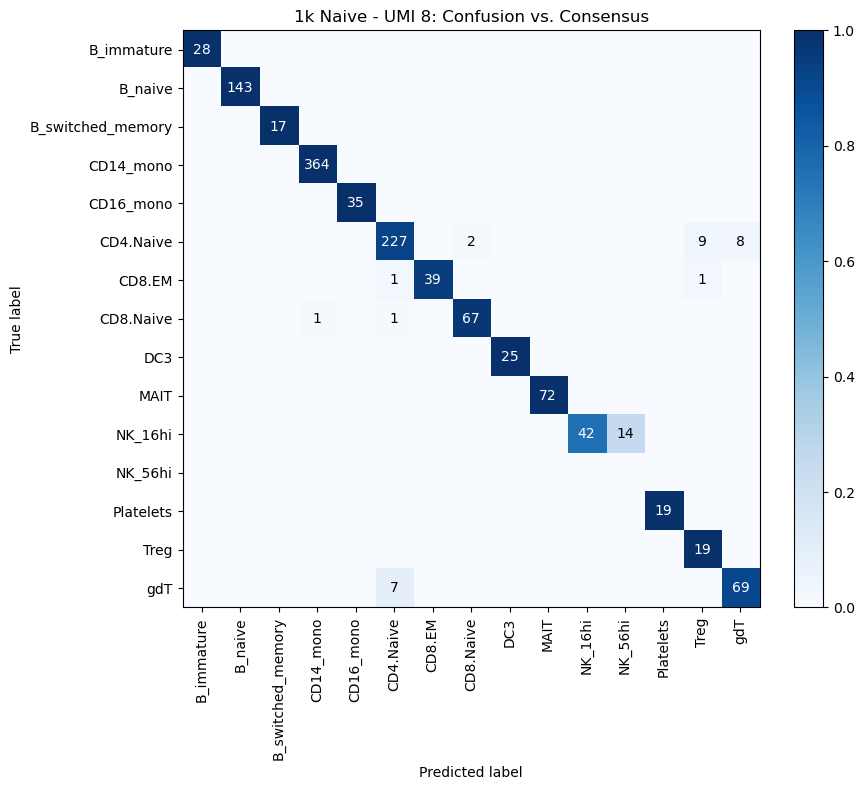


Processing UMI length = 9 …


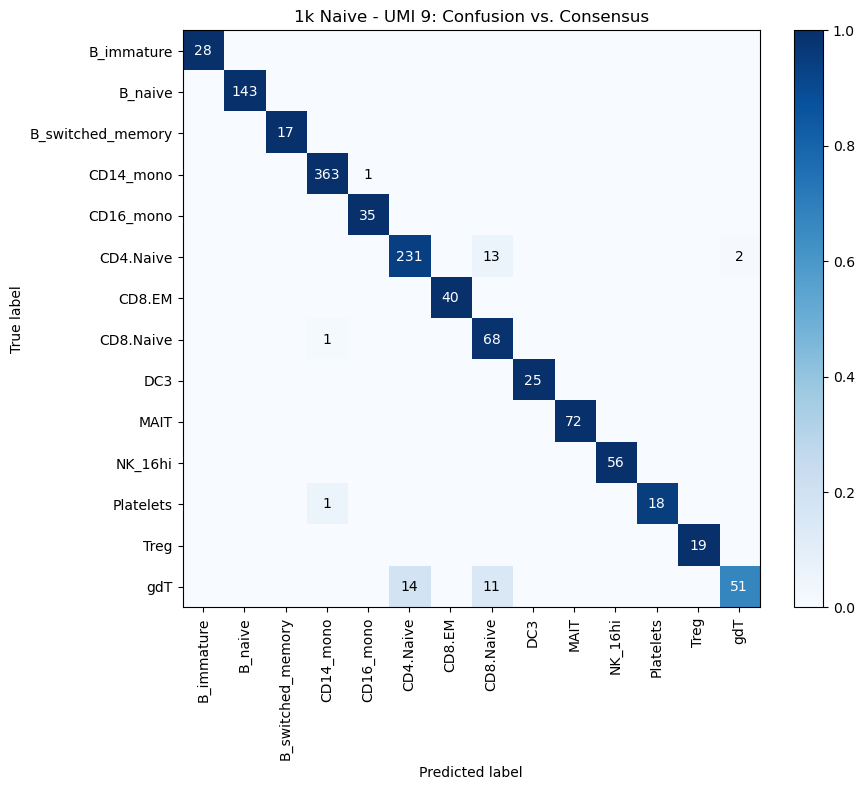


Processing UMI length = 10 …


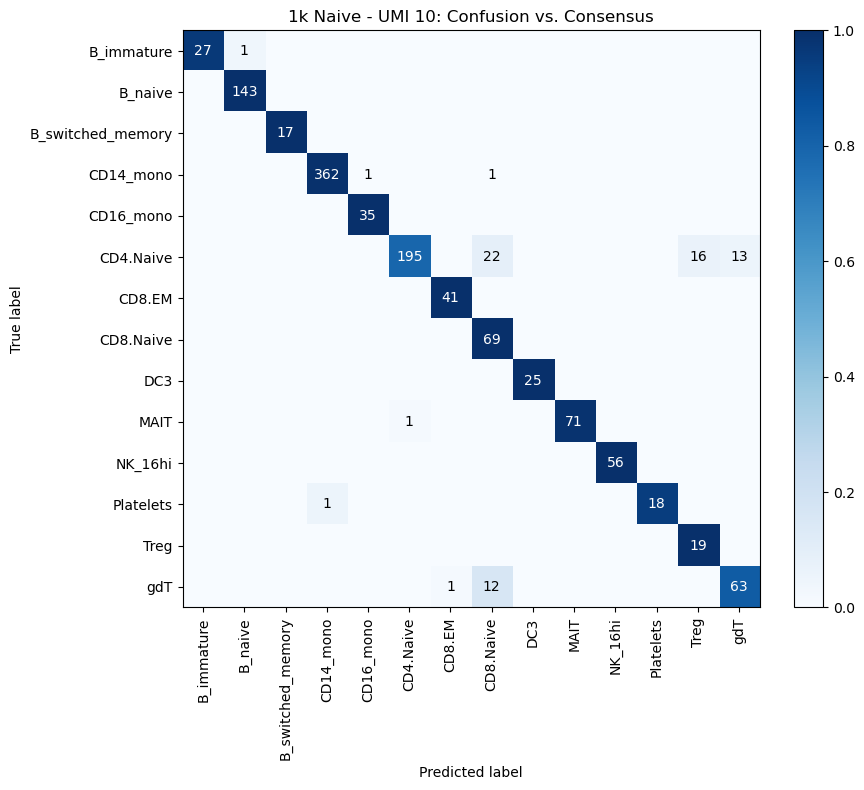


Processing UMI length = 11 …


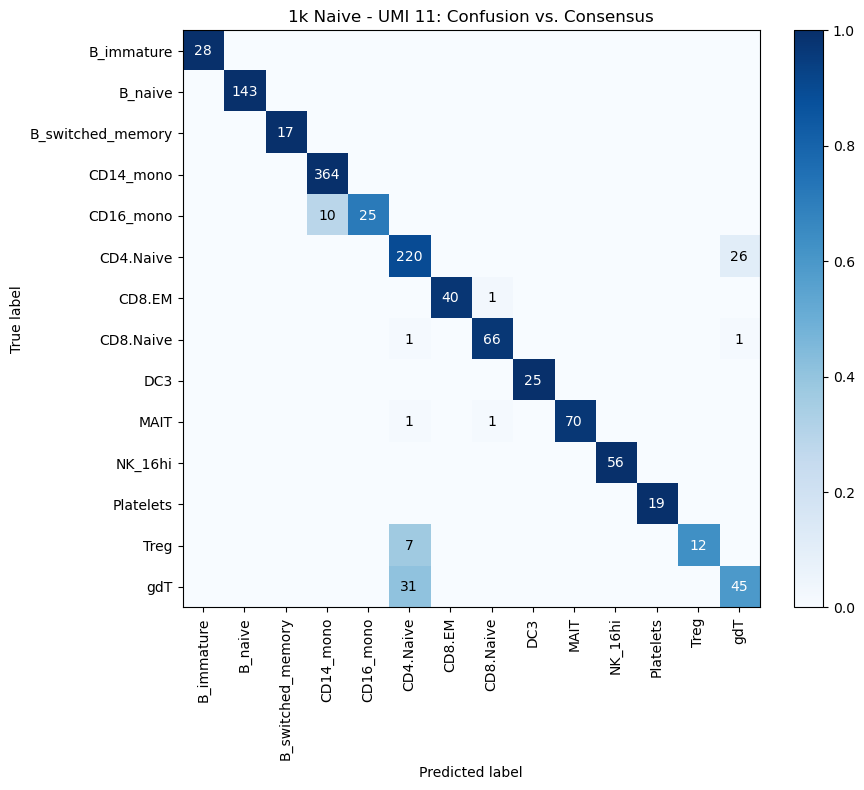


Processing UMI length = 12 …


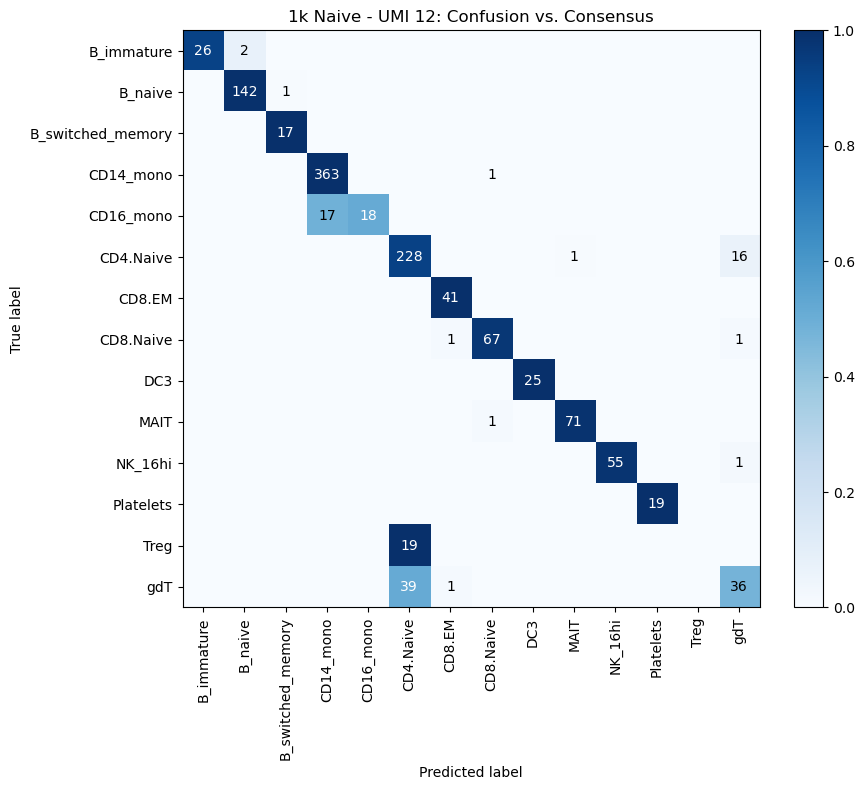

In [4]:
import os
import scanpy as sc
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from collections import Counter
import numpy as np

# ──────────────────────────────────────────────────────────────────────────────
# 0) Paths
base_path = "/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ur_objects/adata_matrices/cell_annotations/annotated_adata_matrices"

# ──────────────────────────────────────────────────────────────────────────────
# 1) Build consensus from UMI 8–12

# load the five Adatas
ensemble_adatas = {
    i: sc.read_h5ad(os.path.join(base_path, f"annotated_adata_{i}.h5ad"))
    for i in range(8, 13)
}

# intersect on common cells
common = set(ensemble_adatas[8].obs_names)
for ad in ensemble_adatas.values():
    common &= set(ad.obs_names)
common_cells = sorted(common)

# majority-vote consensus labels
consensus_labels = {}
for cell in common_cells:
    votes = [ensemble_adatas[i].obs.loc[cell, 'majority_voting'] for i in range(8, 13)]
    consensus_labels[cell] = Counter(votes).most_common(1)[0][0]

# ──────────────────────────────────────────────────────────────────────────────
# 2) Exclude these three from the axes
exclude = {"Plasma_cell_IgG", "CD4.Prolif", "pDC"}

# ──────────────────────────────────────────────────────────────────────────────
# 3) Loop over UMI 1–12
for umi in range(1, 13):
    print(f"\nProcessing UMI length = {umi} …")

    # load this UMI’s AnnData
    adata = sc.read_h5ad(os.path.join(base_path, f"annotated_adata_{umi}.h5ad"))
    # align to consensus cells
    if not all(adata.obs_names == common_cells):
        cells = [c for c in common_cells if c in adata.obs_names]
        print(f"  Aligning to {len(cells)} common cells")
        adata = adata[cells].copy()

    # extract true vs. pred
    y_true = np.array([consensus_labels[c] for c in adata.obs_names], dtype=str)
    y_pred = adata.obs['majority_voting'].astype(str).values

    # determine labels (minus excludes)
    labs = np.unique(np.concatenate([y_true, y_pred]))
    labels = [L for L in labs if L not in exclude]
    n = len(labels)

    # raw confusion counts
    cm = confusion_matrix(y_true, y_pred, labels=labels)

    # row-normalize to get proportions, but set rows with sum=0 to zeros
    row_sums = cm.sum(axis=1, keepdims=True)
    cm_prop = np.divide(
        cm.astype(float),
        row_sums,
        out=np.zeros_like(cm, dtype=float),
        where=row_sums != 0
    )

    # ─── Plot ──────────────────────────────────────────────────────────────────
    fig, ax = plt.subplots(figsize=(10, 8))
    im = ax.imshow(cm_prop, cmap="Blues", vmin=0, vmax=1)

    # ticks & labels
    ax.set_xticks(np.arange(n))
    ax.set_yticks(np.arange(n))
    ax.set_xticklabels(labels, rotation=90, ha="center")
    ax.set_yticklabels(labels)
    ax.set_xlabel("Predicted label")
    ax.set_ylabel("True label")
    ax.set_title(f"1k Naive - UMI {umi}: Confusion vs. Consensus")

    # annotate with raw counts, text color by proportion
    thresh = 0.5
    for r in range(n):
        for c in range(n):
            count = cm[r, c]
            if count == 0:
                continue
            color = "white" if cm_prop[r, c] > thresh else "black"
            ax.text(c, r, str(count), ha="center", va="center", color=color)

    # colorbar
    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    # cbar.set_label("Proportion of true-label cells", rotation=270, labelpad=15)

    plt.tight_layout()
    plt.savefig(f"/data/dagyeman/cellranger/bam_file_analysis/figures_ur/confusion_matrices/1k_naive/consensus/confusion_matrix_UMI_{umi}.pdf")
    plt.show()



### Model

Uniform consensus:   1028/1232 = 83.44%
Mixed consensus:     204/1232 = 16.56%

Processing UMI length = 1 …


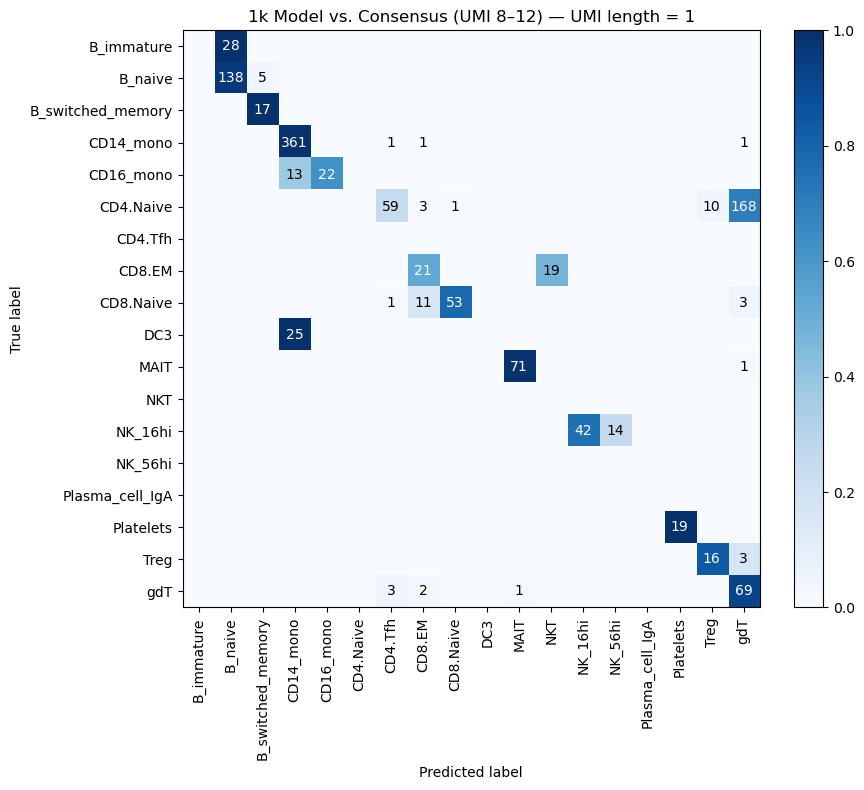

Processing UMI length = 2 …


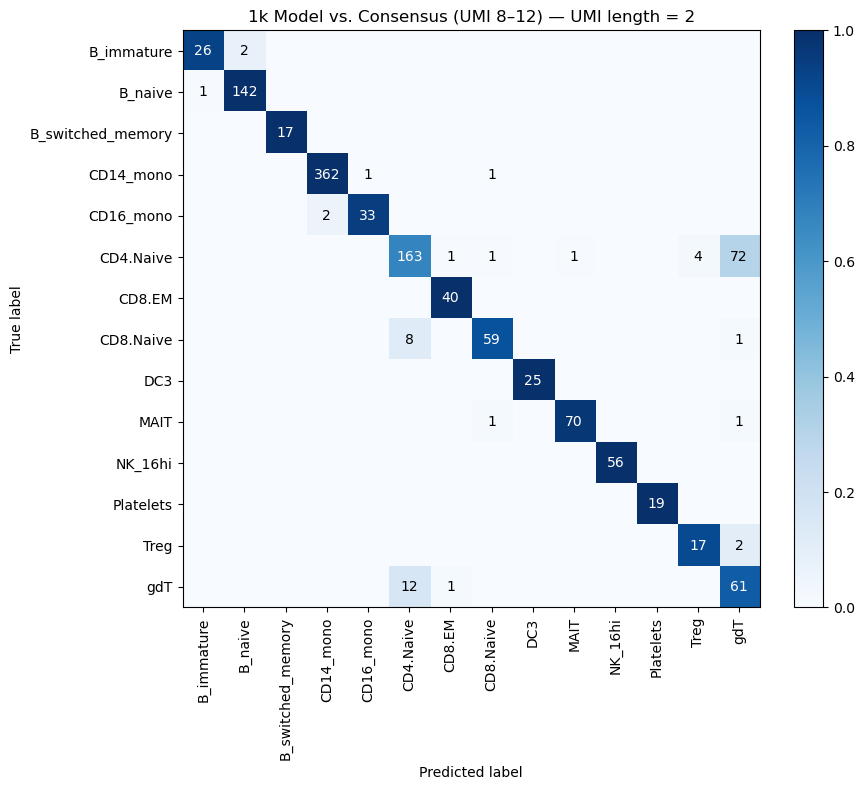

Processing UMI length = 3 …


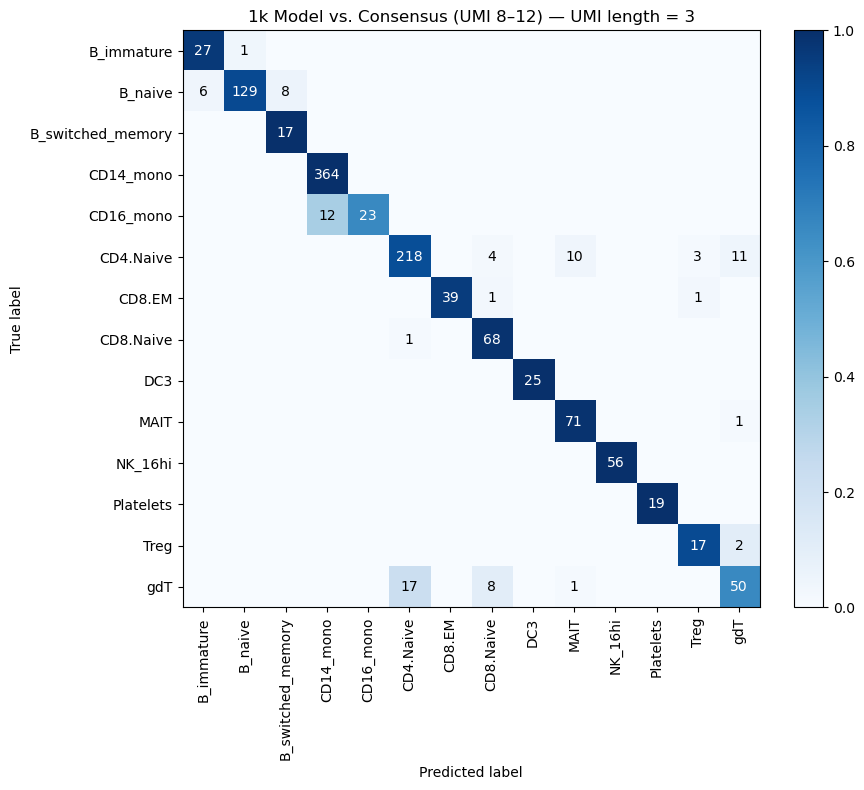

Processing UMI length = 4 …


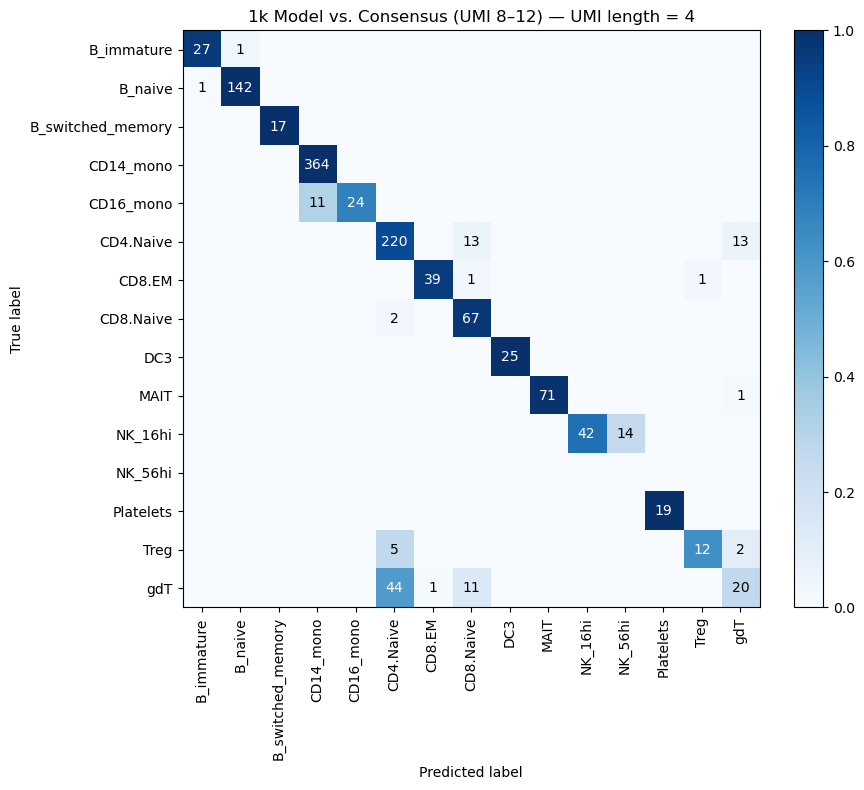

Processing UMI length = 5 …


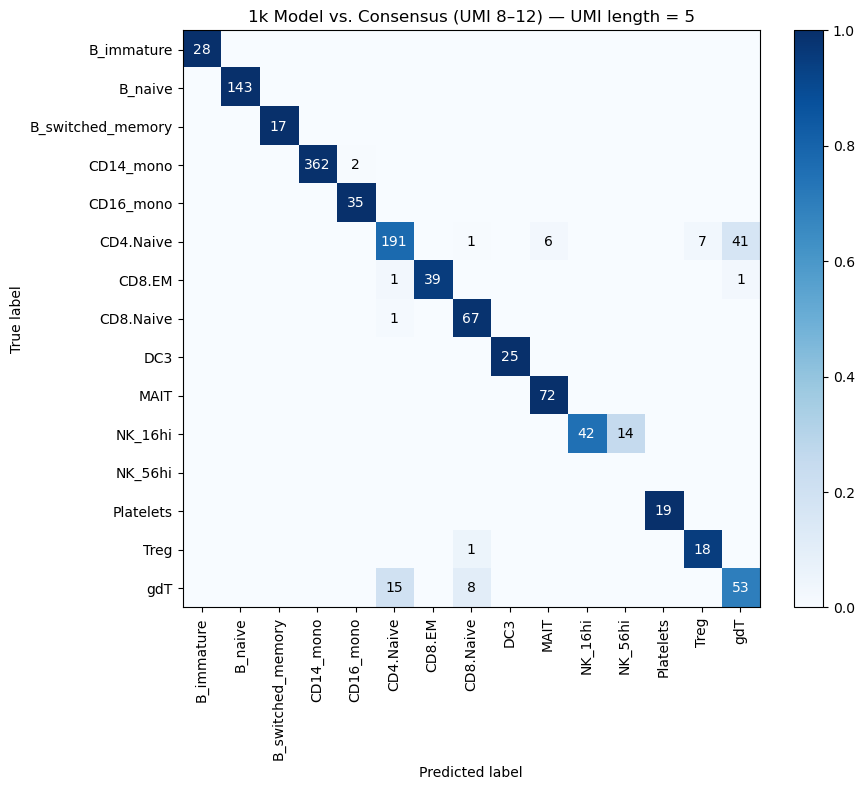

Processing UMI length = 6 …


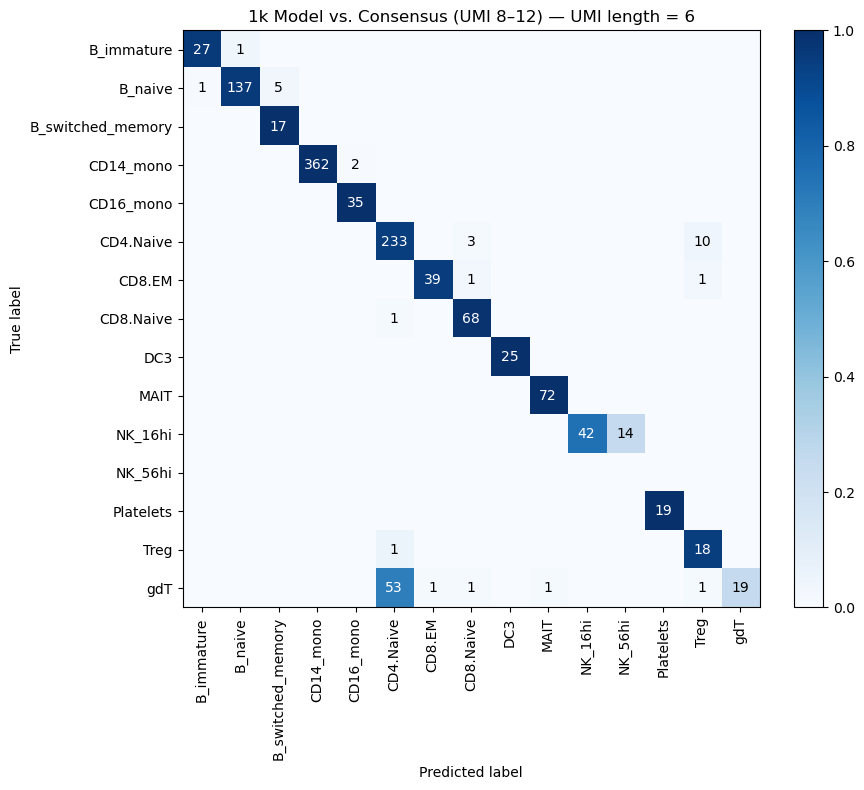

Processing UMI length = 7 …


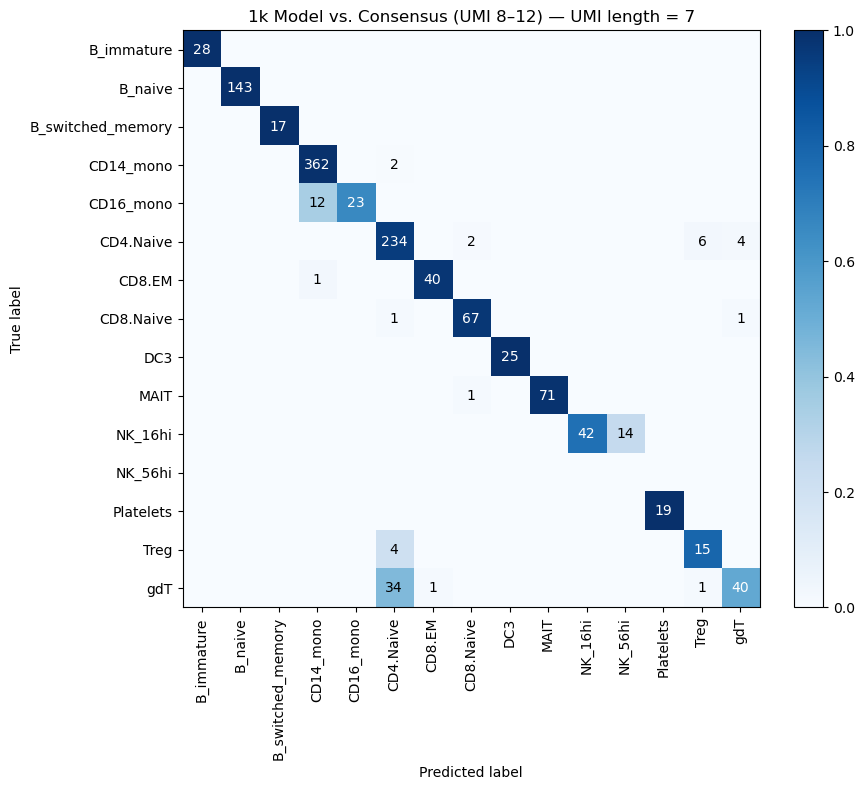

Processing UMI length = 8 …


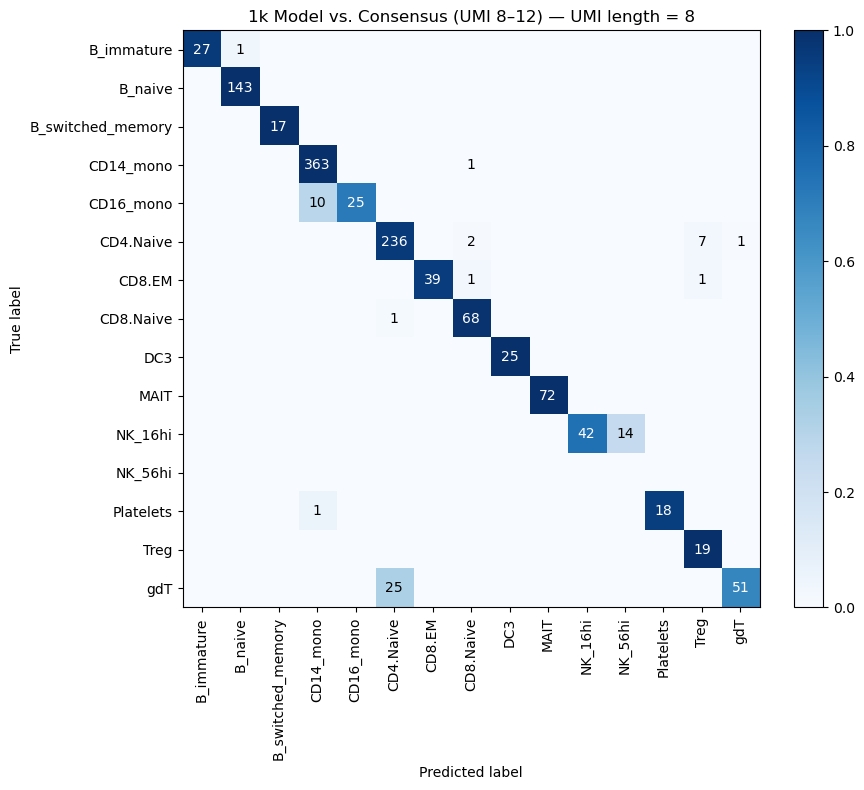

Processing UMI length = 9 …


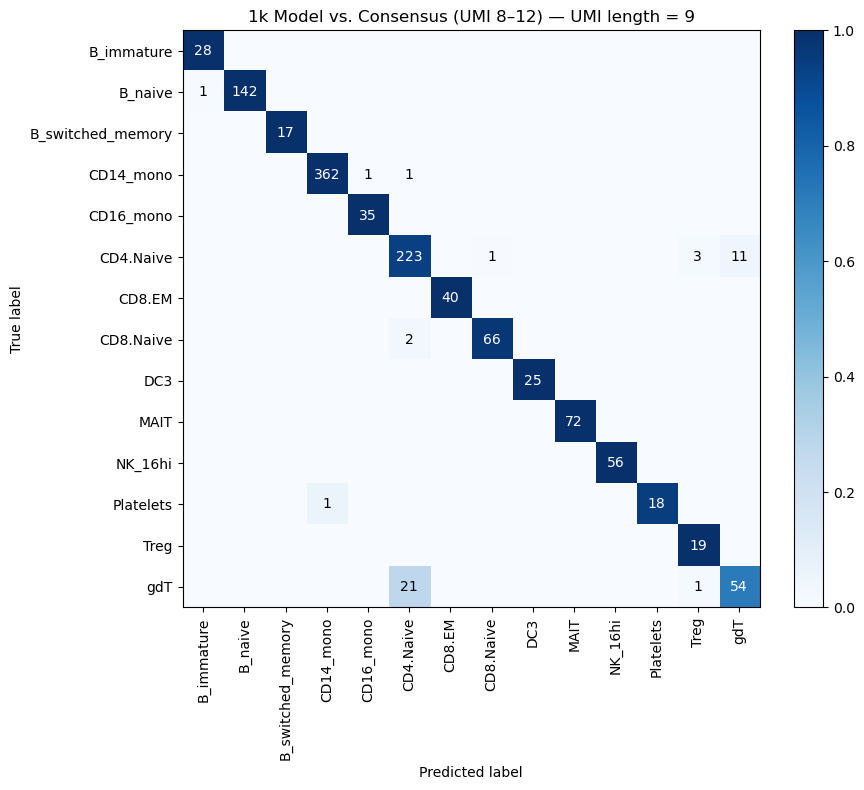

Processing UMI length = 10 …


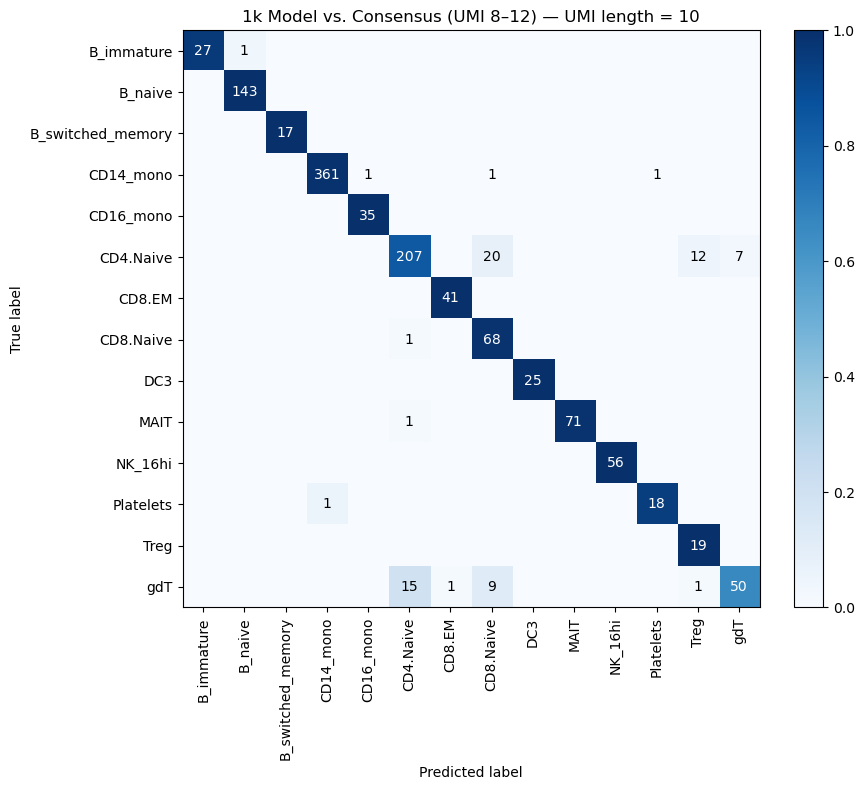

Processing UMI length = 11 …


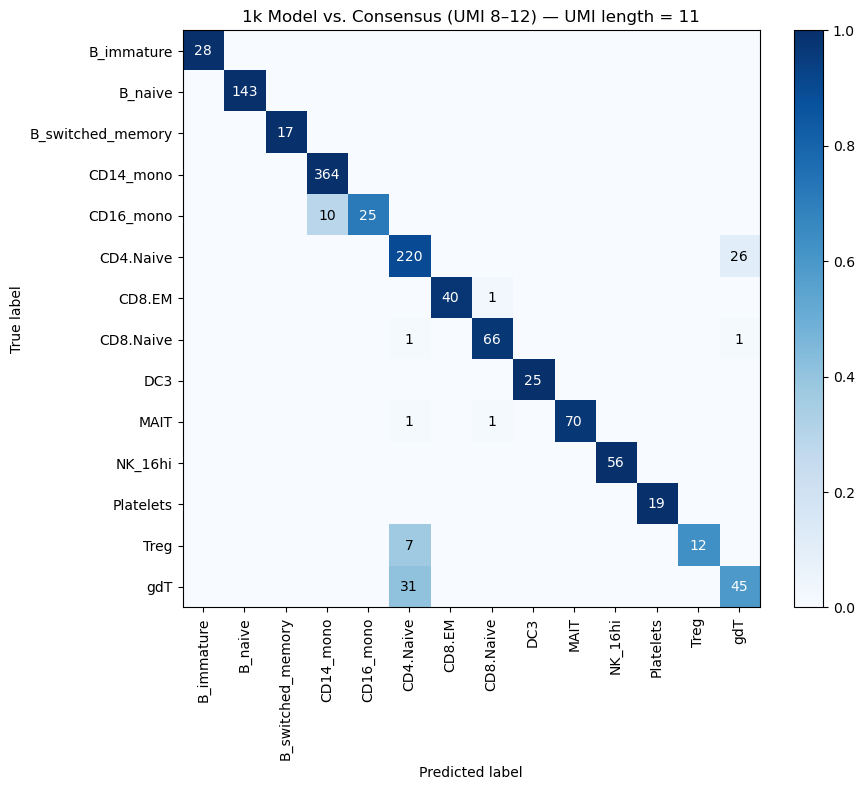

Processing UMI length = 12 …


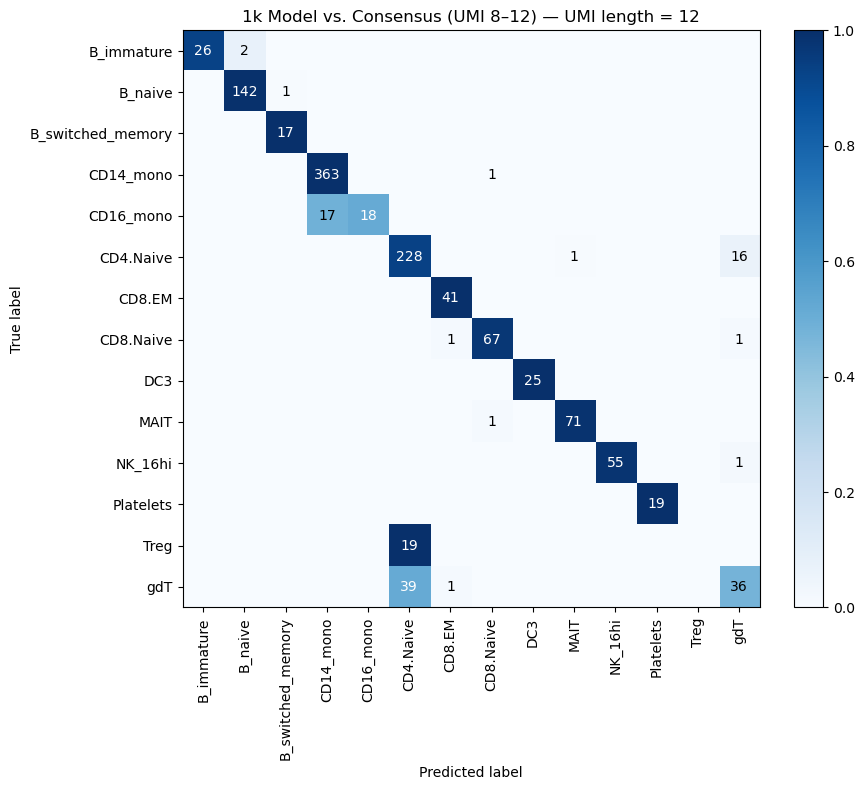

In [5]:
import os
import scanpy as sc
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from collections import Counter
import numpy as np

# ──────────────────────────────────────────────────────────────────────────────
# 0) Paths
model_common_path     = "/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ur_objects/inverted2_adata_matrices/cell_annotations/annotated_inv_matrices"
consensus_base_path   = "/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ur_objects/adata_matrices/cell_annotations/annotated_adata_matrices"

# ──────────────────────────────────────────────────────────────────────────────
# 1) Load ground‐truth Adatas (UMI 8–12) and build consensus

ensemble_adatas = {
    i: sc.read_h5ad(os.path.join(consensus_base_path, f"annotated_adata_{i}.h5ad"))
    for i in range(8, 13)
}

common = set(ensemble_adatas[8].obs_names)
for ad in ensemble_adatas.values():
    common &= set(ad.obs_names)
common_cells = sorted(common)

consensus_labels = {}
for cell in common_cells:
    votes = [ensemble_adatas[i].obs.loc[cell, 'majority_voting'] for i in range(8, 13)]
    consensus_labels[cell] = Counter(votes).most_common(1)[0][0]

# ──────────────────────────────────────────────────────────────────────────────
# 2) Exclude these from the axes
exclude = {"Plasma_cell_IgG", "CD4.Prolif", "pDC"}

# ──────────────────────────────────────────────────────────────────────────────
# 3) Print uniform‐vote stats once
total       = len(common_cells)
uniform     = sum(
    1 for c in common_cells
      if len({ensemble_adatas[i].obs.loc[c, 'majority_voting'] for i in range(8, 13)}) == 1
)
non_uniform = total - uniform
print(f"Uniform consensus:   {uniform}/{total} = {uniform/total*100:.2f}%")
print(f"Mixed consensus:     {non_uniform}/{total} = {non_uniform/total*100:.2f}%\n")

# ──────────────────────────────────────────────────────────────────────────────
# 4) Loop over UMI 1–12, plot confusion (counts & proportion‐color)
for umi in range(1, 13):
    print(f"Processing UMI length = {umi} …")
    
    # load inverted‐model AnnData
    inv_file = os.path.join(model_common_path, f"annotated_adata_{umi}.h5ad")
    inv_adata = sc.read_h5ad(inv_file)
    
    # align to consensus cells
    if not all(inv_adata.obs_names == common_cells):
        cells = [c for c in common_cells if c in inv_adata.obs_names]
        print(f"  Aligning to {len(cells)} common cells")
        inv_adata = inv_adata[cells].copy()
    
    # extract true vs. pred
    y_true = np.array([consensus_labels[c] for c in inv_adata.obs_names], dtype=str)
    y_pred = inv_adata.obs['majority_voting'].astype(str).values

    # determine labels (minus excluded)
    labs   = np.unique(np.concatenate([y_true, y_pred]))
    labels = [L for L in labs if L not in exclude]
    n      = len(labels)
    
    # raw confusion counts
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    
    # row‐normalize (safe divide: zero‐rows → all zeros)
    row_sums = cm.sum(axis=1, keepdims=True)
    cm_prop = np.divide(
        cm.astype(float),
        row_sums,
        out=np.zeros_like(cm, dtype=float),
        where=row_sums != 0
    )
    
    # ─── Plot ──────────────────────────────────────────────────────────────────
    fig, ax = plt.subplots(figsize=(10, 8))
    im = ax.imshow(cm_prop, cmap="Blues", vmin=0, vmax=1)
    
    # ticks & labels
    ax.set_xticks(np.arange(n))
    ax.set_yticks(np.arange(n))
    ax.set_xticklabels(labels, rotation=90, ha="center")
    ax.set_yticklabels(labels)
    ax.set_xlabel("Predicted label")
    ax.set_ylabel("True label")
    ax.set_title(f"1k Model vs. Consensus (UMI 8–12) — UMI length = {umi}")
    
    # annotate with raw counts; text white if prop>0.5
    thresh = 0.5
    for r in range(n):
        for c in range(n):
            cnt = cm[r, c]
            if cnt == 0:
                continue
            color = "white" if cm_prop[r, c] > thresh else "black"
            ax.text(c, r, str(cnt), ha="center", va="center", color=color)
    
    # colorbar
    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    # cbar.set_label("Proportion of true‐label cells", rotation=270, labelpad=15)
    
    plt.tight_layout()
    plt.savefig(f"/data/dagyeman/cellranger/bam_file_analysis/figures_ur/confusion_matrices/1k_model/consensus/confusion_matrix_UMI_{umi}.pdf")
    plt.show()
